# Análise e Previsão de Churn - Telecom X

## 📑 Sumário Interativo

- [Bibliotecas](#Bibliotecas)
- [📌 EXTRAÇÃO](#%F0%9F%93%8D-EXTRA%C3%87%C3%83O)
- [🛠️ Preparação dos Dados](#%F0%9F%94%A8%EF%B8%8F-Prepara%C3%A7%C3%A3o-dos-Dados)
  - [Removendo colunas desncessárias](#Removendo-colunas-desncess%C3%A1rias)
  - [One Hot Encoding](#One-Hot-Encoding)
    - [Checando alterações](#Checando-altera%C3%A7%C3%B5es)
- [🔢 Correlação entre as variáveis](#%F0%9F%97%AA%EF%B8%8F-Correla%C3%A7%C3%A3o-entre-as-vari%C3%A1veis)
  - [Dividir Variáveis explicativas da Variável alvo](#Dividir-Vari%C3%A1veis-explicativas-da-Vari%C3%A1vel-alvo)
  - [🔍 Análise de Multicolinearidade](#%F0%9F%94%8D-An%C3%A1lise-de-Multicolinearidade)
    - [FIV REFEITA](#FIV-REFEITA)
    - [FIV FINAL](#FIV-FINAL)
  - [Dataset tratado pronto para etapa de construção e testes de modelos](#Dataset-tratado-pronto-para-etapa-de-constru%C3%A7%C3%A3o-e-testes-de-modelos)
- [🤖 Modelos Preditivos](#%F0%9F%A4%96-Modelos-Preditivos)
  - [Treinamento e validação](#Treinamento-e-valida%C3%A7%C3%A3o)
  - [Otimização de Hiperparâmetros](#Otimiza%C3%A7%C3%A3o-de-Hiperpar%C3%A2metros)
    - [Otimização do modelo RandomForestClassifier](#Otimiza%C3%A7%C3%A3o-do-modelo-RandomForestClassifier)
    - [Otimização do modelo XGBoost](#Otimiza%C3%A7%C3%A3o-do-modelo-XGBoost)
    - [Validação cruzada e estatistícas dos modelos otimizados](#Valida%C3%A7%C3%A3o-cruzada-e-estatist%C3%ADcas-dos-modelos-otimizados)
- [💡 Análise de importância das Features](#%F0%9F%92%A1-An%C3%A1lise-de-import%C3%A2ncia-das-Features)
  - [Análises Direcionadas](#An%C3%A1lises-Direcionadas)
- [📃 **Relatório Final**](#%F0%9F%93%8D-%2A%2ARelat%C3%B3rio-Final%2A%2A)
  - [➕ Análise Comparativa: RF - SMOTE vs XGB - Under Sampling](#%E2%9E%A0-An%C3%A1lise-Comparativa:-RF---SMOTE-vs-XGB---Under-Sampling)

## Bibliotecas

In [204]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve, precision_recall_curve)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import pickle
import os

##📌 EXTRAÇÃO

In [205]:
"""
Para acessar o dataset do ultimo challenge Usei o link do arquivo raw no github,
a fim de facilitar a visualização utilização do projeto. Em ambiente de produção
esse arquivo seria confidencial e seria acessado seguindo padrões de segurança.
"""
url = 'https://raw.githubusercontent.com/LucasEstevesCosta/Challenge-Telecom-X-Analise-de-evasao-de-clientes-Parte-2/refs/heads/main/clientes_telecom_x.csv'
df = pd.read_csv(url)
df.head()

,id_cliente,evasao,genero,idoso,parceiro,dependentes,meses_contrato,servico_telefone,multiplas_linhas,servico_internet,...,protecao_dispositivo,suporte_tecnico,tv_streaming,filmes_streaming,tipo_contrato,fatura_digital,metodo_pagamento,contas_diarias,cobranca_mensal,cobranca_total
0,0002-orfbo,nao,mulher,nao,sim,sim,9,sim,nao,dsl,...,nao,sim,sim,nao,anual,sim,cheque correios,2.20,65.6,593.30
1,0003-mknfe,nao,homem,nao,nao,nao,9,sim,sim,dsl,...,nao,nao,nao,sim,mensal,nao,cheque correios,2.01,59.9,542.40
2,0004-tlhlj,sim,homem,nao,nao,nao,4,sim,nao,fibra otica,...,sim,nao,nao,nao,mensal,sim,cheque eletronico,2.34,73.9,280.85
3,0011-igkff,sim,homem,sim,sim,nao,13,sim,nao,fibra otica,...,sim,nao,sim,sim,mensal,sim,cheque eletronico,3.17,98.0,1237.85
4,0013-exchz,sim,mulher,sim,sim,nao,3,sim,nao,fibra otica,...,nao,sim,sim,nao,mensal,sim,cheque correios,2.97,83.9,267.40


In [206]:
# Verifica as colunas disponíveis
df.columns

Index(['id_cliente', 'evasao', 'genero', 'idoso', 'parceiro', 'dependentes',
       'meses_contrato', 'servico_telefone', 'multiplas_linhas',
       'servico_internet', 'protecao_online', 'backup_online',
       'protecao_dispositivo', 'suporte_tecnico', 'tv_streaming',
       'filmes_streaming', 'tipo_contrato', 'fatura_digital',
       'metodo_pagamento', 'contas_diarias', 'cobranca_mensal',
       'cobranca_total'],
      dtype='object')

In [207]:
# Verifica a estrutura geral
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id_cliente            7043 non-null   object 
 1   evasao                7043 non-null   object 
 2   genero                7043 non-null   object 
 3   idoso                 7043 non-null   object 
 4   parceiro              7043 non-null   object 
 5   dependentes           7043 non-null   object 
 6   meses_contrato        7043 non-null   int64  
 7   servico_telefone      7043 non-null   object 
 8   multiplas_linhas      7043 non-null   object 
 9   servico_internet      7043 non-null   object 
 10  protecao_online       7043 non-null   object 
 11  backup_online         7043 non-null   object 
 12  protecao_dispositivo  7043 non-null   object 
 13  suporte_tecnico       7043 non-null   object 
 14  tv_streaming          7043 non-null   object 
 15  filmes_streaming     

In [208]:
# Verifica colunas categoricas
df.describe(include='O')

,id_cliente,evasao,genero,idoso,parceiro,dependentes,servico_telefone,multiplas_linhas,servico_internet,protecao_online,backup_online,protecao_dispositivo,suporte_tecnico,tv_streaming,filmes_streaming,tipo_contrato,fatura_digital,metodo_pagamento
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,9995-hotoh,nao,homem,nao,nao,nao,sim,nao,fibra otica,nao,nao,nao,nao,nao,nao,mensal,sim,cheque eletronico
freq,1,5174,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365


In [209]:
# Verifica valores ausentes
df.isna().sum()

,0
id_cliente,0
evasao,0
genero,0
idoso,0
parceiro,0
dependentes,0
meses_contrato,0
servico_telefone,0
multiplas_linhas,0
servico_internet,0


##🛠️ Preparação dos Dados

### Removendo colunas desncessárias

In [210]:
# Remove a coluna 'id_cliente' pois não têm valor preditivo
df = df.drop(columns=['id_cliente'])

In [211]:
df.head(5)

,evasao,genero,idoso,parceiro,dependentes,meses_contrato,servico_telefone,multiplas_linhas,servico_internet,protecao_online,...,protecao_dispositivo,suporte_tecnico,tv_streaming,filmes_streaming,tipo_contrato,fatura_digital,metodo_pagamento,contas_diarias,cobranca_mensal,cobranca_total
0,nao,mulher,nao,sim,sim,9,sim,nao,dsl,nao,...,nao,sim,sim,nao,anual,sim,cheque correios,2.20,65.6,593.30
1,nao,homem,nao,nao,nao,9,sim,sim,dsl,nao,...,nao,nao,nao,sim,mensal,nao,cheque correios,2.01,59.9,542.40
2,sim,homem,nao,nao,nao,4,sim,nao,fibra otica,nao,...,sim,nao,nao,nao,mensal,sim,cheque eletronico,2.34,73.9,280.85
3,sim,homem,sim,sim,nao,13,sim,nao,fibra otica,nao,...,sim,nao,sim,sim,mensal,sim,cheque eletronico,3.17,98.0,1237.85
4,sim,mulher,sim,sim,nao,3,sim,nao,fibra otica,nao,...,nao,sim,sim,nao,mensal,sim,cheque correios,2.97,83.9,267.40


A coluna 'id_cliente' foi removida pois não têm valor preditivo.

In [212]:
df['metodo_pagamento'] = df['metodo_pagamento'].replace({
    'cheque eletronico': 'boleto eletronico',
    'cheque correios': 'boleto correios'})

Substitui 'cheque correios' por 'boleto eletronico' e 'cheque correios' por 'boleto correios' a fim de facilitar a compreensão das variáveis.

### One Hot Encoding

In [213]:
# Fazendo uma cópia do DataFrame
df_clean = df.copy()

In [214]:
# Separa variável as colunas categóricas
colunas_categoricas = df_clean.select_dtypes(include=['object']).columns
colunas_categoricas

Index(['evasao', 'genero', 'idoso', 'parceiro', 'dependentes',
       'servico_telefone', 'multiplas_linhas', 'servico_internet',
       'protecao_online', 'backup_online', 'protecao_dispositivo',
       'suporte_tecnico', 'tv_streaming', 'filmes_streaming', 'tipo_contrato',
       'fatura_digital', 'metodo_pagamento'],
      dtype='object')

Como encontramos colinearidade nas colunas de serviço de internet, mais especificamente entre as categorias 'nao' e 'sem internet', vamos agrupar essas duas categorias. Esse tratamento foi escolhido visto que a informação de que o cliente tem ou não serviço de internet está presente na coluna 'servico_internet'.

In [215]:
# Colunas que vamos fazer o agrupamento das categorias 'nao' e 'sem internet'
colunas_para_tratar = ['protecao_online', 'backup_online', 'protecao_dispositivo',
                      'suporte_tecnico', 'tv_streaming', 'filmes_streaming']

# Agrupar 'nao' e 'sem internet'
for coluna in colunas_para_tratar:
    df_clean[coluna] = df_clean[coluna].replace({'sem internet': 'nao'})

In [216]:
df_clean.describe(include='O')

,evasao,genero,idoso,parceiro,dependentes,servico_telefone,multiplas_linhas,servico_internet,protecao_online,backup_online,protecao_dispositivo,suporte_tecnico,tv_streaming,filmes_streaming,tipo_contrato,fatura_digital,metodo_pagamento
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,2,3,3,2,2,2,2,2,2,3,2,4
top,nao,homem,nao,nao,nao,sim,nao,fibra otica,nao,nao,nao,nao,nao,nao,mensal,sim,boleto eletronico
freq,5174,3555,5901,3641,4933,6361,3390,3096,5024,4614,4621,4999,4336,4311,3875,4171,2365


#### Encoding com OneHotEncoder da biblioteca Scikit Learn

Criando o Encoder com OneHotEncoder do Scikit Learn

In [217]:
# Inicializa o encoder
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), colunas_categoricas),
    remainder='passthrough'
)

In [218]:
# Treina o one_hot_encoder e ajustando os dados
df_encoded = one_hot_encoder.fit_transform(df_clean)
df_encoded = pd.DataFrame(df_encoded, columns=one_hot_encoder.get_feature_names_out())

In [219]:
# Renomea as colunas para remover os prefixos inseridos pelo OneHotEncoder
df_encoded.columns = df_encoded.columns.str.replace('onehotencoder__', '').str.replace('remainder__', '')

#### Checando alterações

In [220]:
df_encoded.head()

,evasao_sim,genero_mulher,idoso_sim,parceiro_sim,dependentes_sim,servico_telefone_sim,multiplas_linhas_sem telefone,multiplas_linhas_sim,servico_internet_fibra otica,servico_internet_nao,...,tipo_contrato_bienal,tipo_contrato_mensal,fatura_digital_sim,metodo_pagamento_boleto eletronico,metodo_pagamento_cartao credito automatico,metodo_pagamento_transferencia automatica,meses_contrato,contas_diarias,cobranca_mensal,cobranca_total
0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,9.0,2.20,65.6,593.30
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,9.0,2.01,59.9,542.40
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,4.0,2.34,73.9,280.85
3,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,13.0,3.17,98.0,1237.85
4,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,3.0,2.97,83.9,267.40


In [221]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   evasao_sim                                  7043 non-null   float64
 1   genero_mulher                               7043 non-null   float64
 2   idoso_sim                                   7043 non-null   float64
 3   parceiro_sim                                7043 non-null   float64
 4   dependentes_sim                             7043 non-null   float64
 5   servico_telefone_sim                        7043 non-null   float64
 6   multiplas_linhas_sem telefone               7043 non-null   float64
 7   multiplas_linhas_sim                        7043 non-null   float64
 8   servico_internet_fibra otica                7043 non-null   float64
 9   servico_internet_nao                        7043 non-null   float64
 10  protecao_onl

In [222]:
# Verifica 'contas_diarias' onde vimos a existência fr valores nulos com info()
print(df_encoded['contas_diarias'].isnull().sum())

11


In [223]:
# Remove linhas com valores nulos nas colunas especificadas
df_encoded = df_encoded.dropna(subset=['contas_diarias'])

Foram encontrados 11 NaN que foram tratados com a remoção dos registros.

## 🔢 Correlação entre as variáveis

In [224]:
palette = [
    '#6f00ff',  # violeta
    '#3f82ff',  # azul
    '#00b7ff',  # azul claro / ciano
    '#7fffd4',  # aquamarine
    '#baffc9',  # verde claro
    '#ffe49c',  # amarelo claro
    '#ffc07a',  # laranja claro
    '#ff766a'   # vermelho claro
]

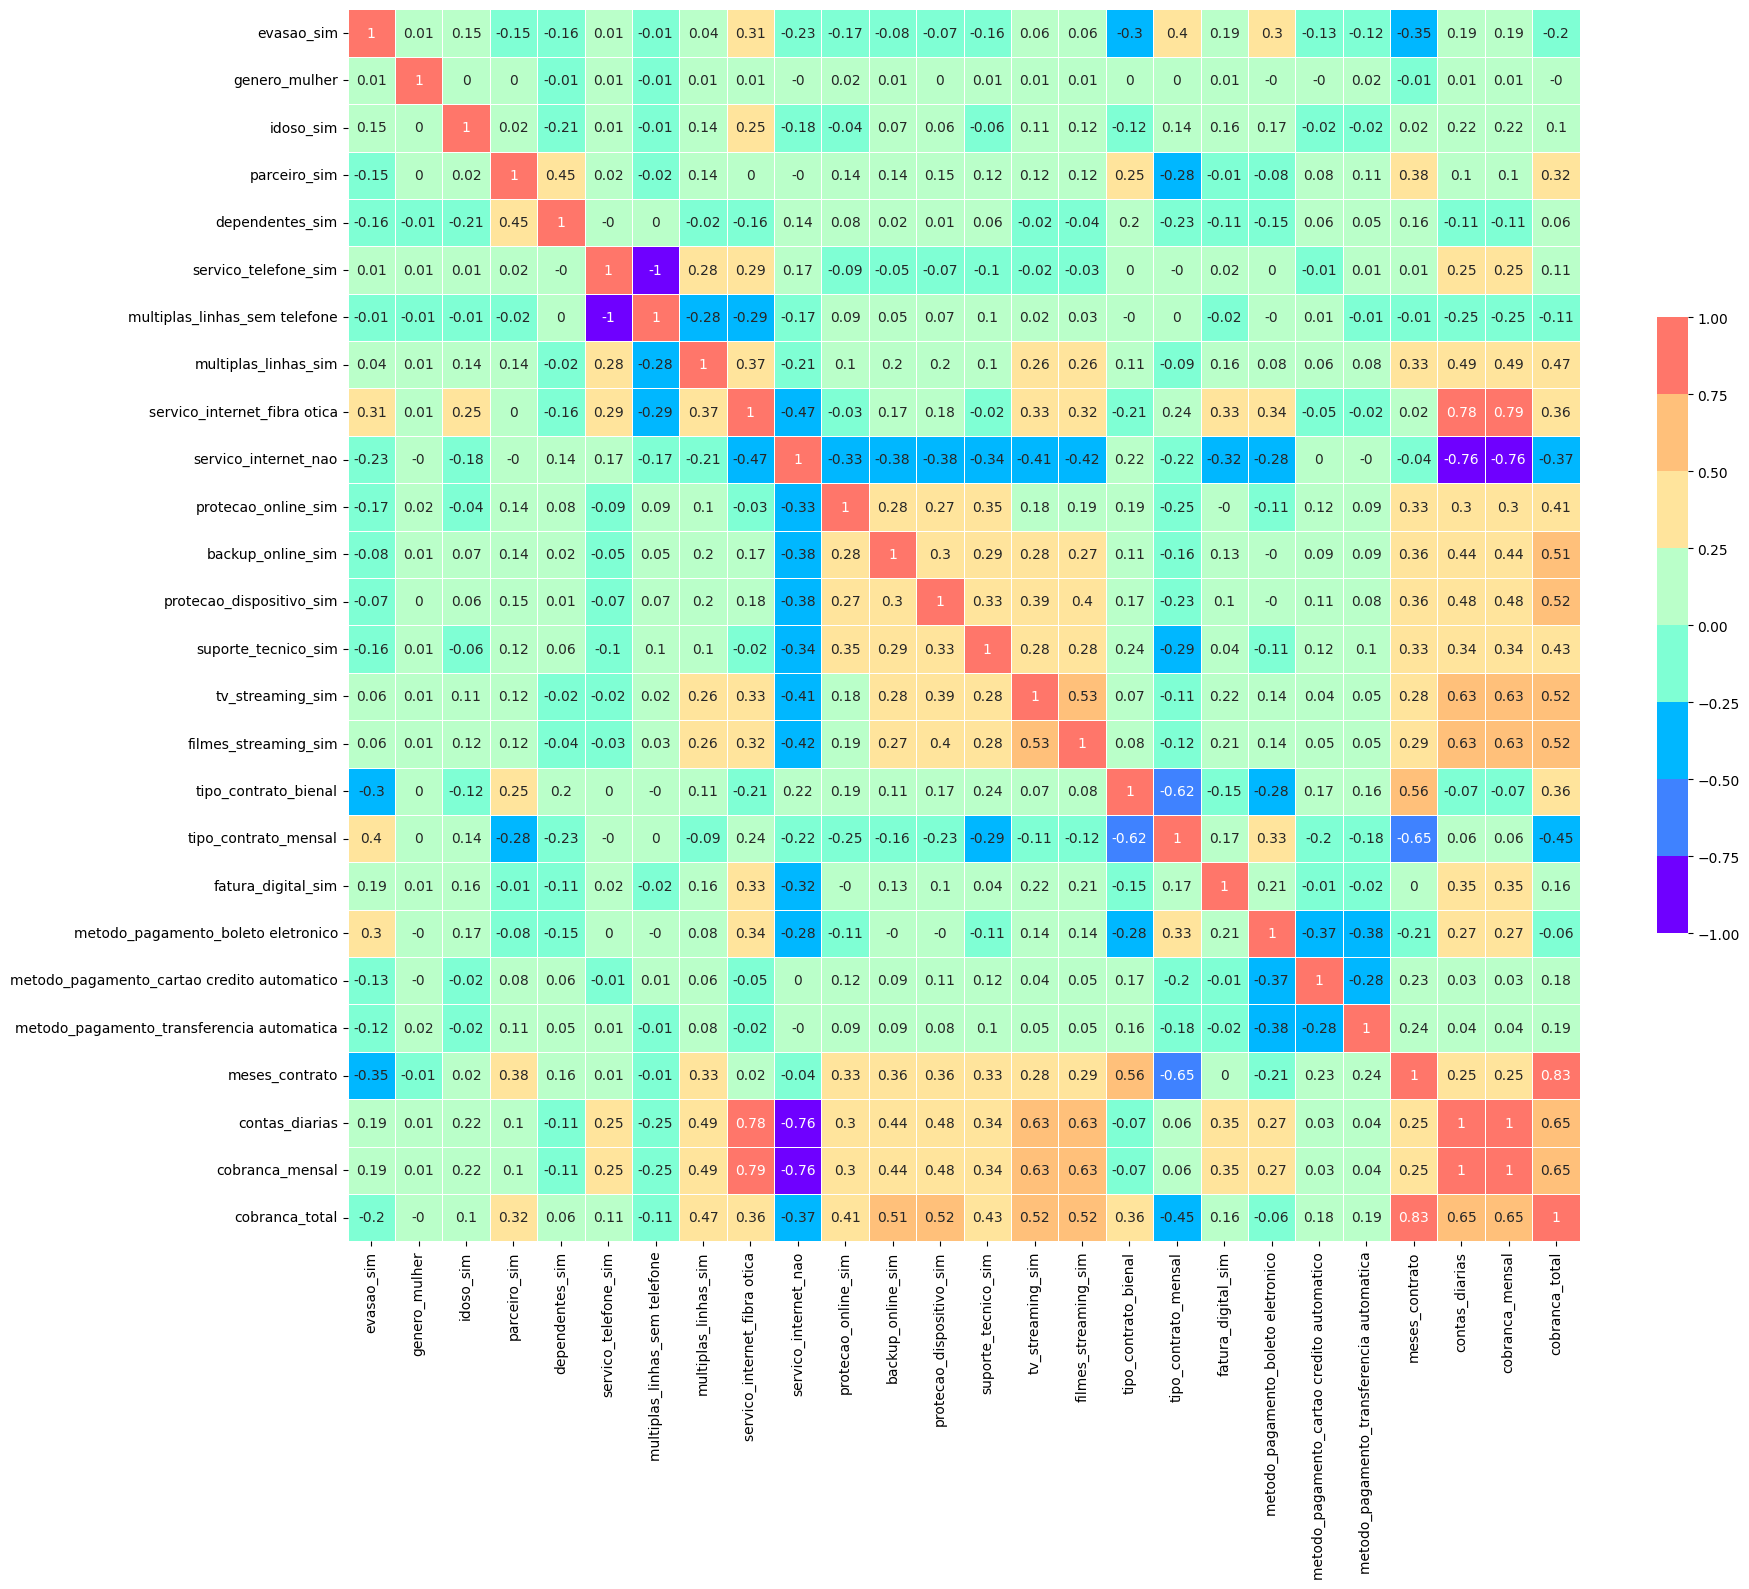

In [225]:
corr = df_encoded.corr()

fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr, 2), vmax=1, vmin=-1, center=0, cmap=palette,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.show()

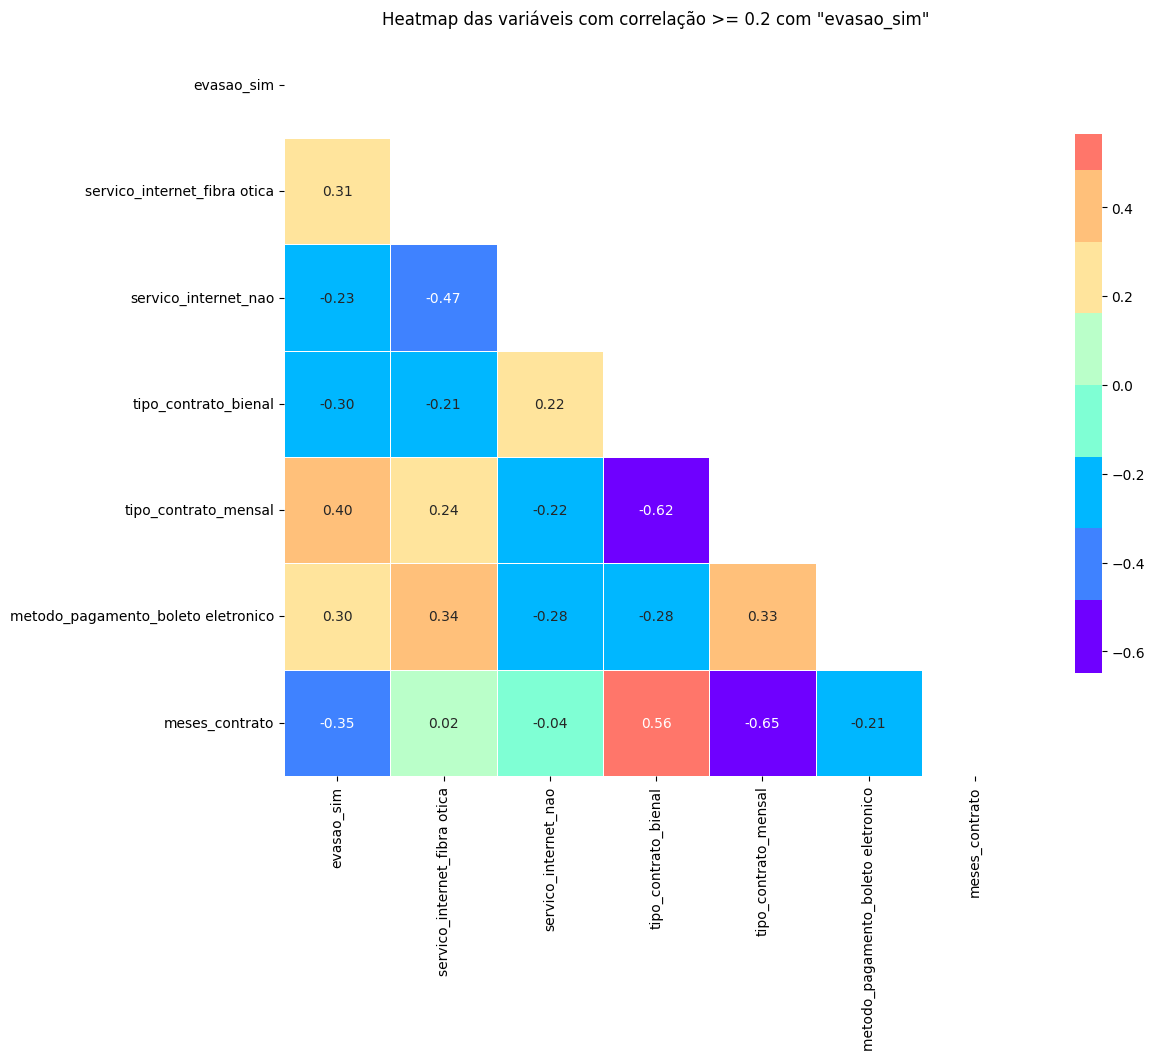

In [226]:
target_var = 'evasao_sim' # Variável alvo

limiar = 0.2 # Limiar mínimo de correlação absoluta para seleção

# Cria uma lista com as variáveis relevantes usando a correlação como filtro
variaveis_relevantes = corr.index[abs(corr[target_var]) >= limiar].tolist()

# Garantir que a variável alvo está na lista (se não estiver, adiciona)
if target_var not in variaveis_relevantes:
    variaveis_relevantes.append(target_var)

# Criar uma matriz de correlação somente com as variáveis selecionadas
corr_filtrada = corr.loc[variaveis_relevantes, variaveis_relevantes]

# Gerar uma máscara para esconder o triângulo superior da matriz (incluindo diagonal)
mascara = np.triu(np.ones_like(corr_filtrada, dtype=bool))

# Plotar o heatmap com a máscara aplicada para melhor visualização
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_filtrada,
    annot=True,
    fmt=".2f",
    cmap=palette, # Alteração aqui
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
    mask=mascara
)
plt.title(f'Heatmap das variáveis com correlação >= {limiar} com "{target_var}"')
plt.show()

**Correlação com `evasao_sim` (variável alvo)**

| Variável                                 | Correlação com evasao_sim | Interpretação                                                                                                   |
| ---------------------------------------- | ------------------------- | --------------------------------------------------------------------------------------------------------------- |
| `servico_internet_fibra otica`   | **+0.31**                 | Clientes com fibra ótica têm **maior chance de churn**. Pode estar relacionado ao custo ou à competitividade.   |
| `metodo_pagamento_boleto eletronico` | **+0.30**                 | Pagamentos por boleto eletrônico estão associados a mais churn — talvez por perfil de cliente menos fidelizado. |
| `tipo_contrato_bienal`              | **-0.30**                 | Contratos de 2 anos reduzem o churn (clientes mais engajados ou com benefícios)                                 |
| `meses_contrato`                        | **-0.35**                 | Quanto maior o tempo como cliente, menor a chance de churn — esperado                                           |
| `servico_internet_nao`            | **-0.23**                 | Quem **não usa internet** tem menor chance de churn — possivelmente perfis mais estáveis (idosos, menos digitais)   |





### Dividir Variáveis explicativas da Variável alvo

In [227]:
# Selecionar as variáveis independentes
X = df_encoded.drop(columns=['evasao_sim'])

In [228]:
# Selecionar variável alvo
y = df_encoded['evasao_sim']

### 🔍 Análise de Multicolinearidade

A Análise de Multicolinearidade será executada pois pretende-se usar um modelo de Regressão Logística.

In [229]:
# Adicionar constante (intercepto)
X_const = add_constant(X)

In [230]:
X_const = X_const.astype(float)

# Calcular o VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Exibir os resultados
display(vif_data.sort_values(by='VIF', ascending=False))

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
6,multiplas_linhas_sem telefone,inf
5,servico_telefone_sim,inf
24,cobranca_mensal,992.623632
8,servico_internet_fibra otica,148.504277
23,contas_diarias,133.792125
9,servico_internet_nao,104.217179
15,filmes_streaming_sim,24.158588
14,tv_streaming_sim,24.080021
25,cobranca_total,10.871350
22,meses_contrato,7.613525


**FIV REFEITA**

In [231]:
# Copiar X_const para não modificar o original
X_filtered = X_const.copy()
X_filtered = X_filtered.astype(float)

# Remover variáveis com alta multicolinearidade
cols_to_drop = [
    "servico_telefone_sim",
    "multiplas_linhas_sem telefone",
    "contas_diarias"
]
X_filtered.drop(columns=cols_to_drop, inplace=True)

# Recalcular o VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_filtered.columns
vif_data["VIF"] = [variance_inflation_factor(X_filtered.values, i) for i in range(X_filtered.shape[1])]

# Exibir os resultados
display(vif_data.sort_values(by="VIF", ascending=False))


,feature,VIF
0,const,88.035950
21,cobranca_mensal,35.340431
22,cobranca_total,10.810996
6,servico_internet_fibra otica,10.115348
20,meses_contrato,7.584286
7,servico_internet_nao,4.845675
12,tv_streaming_sim,2.454781
13,filmes_streaming_sim,2.434019
15,tipo_contrato_mensal,2.430095
17,metodo_pagamento_boleto eletronico,2.183556


**FIV FINAL**

In [232]:
# Remover a variável cobranca_total
X_final = X_filtered.drop(columns=["cobranca_mensal"])

# Recalcular o VIF
vif_data_final = pd.DataFrame()
vif_data_final["feature"] = X_final.columns
vif_data_final["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]

# Exibir os resultados ordenados
display(vif_data_final.sort_values(by="VIF", ascending=False))


,feature,VIF
0,const,22.465945
21,cobranca_total,10.258987
20,meses_contrato,7.212462
7,servico_internet_nao,2.491198
15,tipo_contrato_mensal,2.427772
6,servico_internet_fibra otica,2.262753
17,metodo_pagamento_boleto eletronico,2.183556
14,tipo_contrato_bienal,1.886267
19,metodo_pagamento_transferencia automatica,1.804871
18,metodo_pagamento_cartao credito automatico,1.777222


### Dataset tratado pronto para etapa de construção e testes de modelos

In [233]:
X = X_final.copy()

## 🤖 Modelos Preditivos

### Treinamento e validação

In [234]:
# =============================================================================
# CONFIGURAÇÃO DOS DADOS E PARÂMETROS
# =============================================================================

# Assumindo que X e y já estão definidos
# X = seus dados de features
# y = sua variável target (0 = não churn, 1 = churn)

random_state = 42
test_size = 0.2

# Split dos dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)

# Calcular scale_pos_weight dinâmico para XGBoost
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Dados de treino: {X_train.shape[0]} amostras")
print(f"Dados de teste: {X_test.shape[0]} amostras")
print(f"Taxa de churn: {y.mean():.2%}")
print(f"Scale pos weight calculado: {pos_weight:.2f}\n")



Dados de treino: 5625 amostras
Dados de teste: 1407 amostras
Taxa de churn: 26.58%
Scale pos weight calculado: 2.76



In [235]:
# =============================================================================
# CRIAÇÃO INDIVIDUAL DOS MODELOS
# =============================================================================

# Random Forest com Class Weights
rf_class_weights = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=random_state,
        n_jobs=-1
    ))
])

# Random Forest com SMOTE
rf_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=random_state)),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight=None,
        random_state=random_state,
        n_jobs=-1
    ))
])

# Random Forest com Under Sampling
rf_undersample = ImbPipeline([
    ('scaler', StandardScaler()),
    ('undersampler', ClusterCentroids(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight=None,
        random_state=random_state,
        n_jobs=-1
    ))
])

# XGBoost com Class Weights
xgb_class_weights = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=pos_weight,
        random_state=random_state,
        eval_metric='logloss'
    ))
])

# XGBoost com SMOTE
xgb_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=random_state)),
    ('classifier', xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        random_state=random_state,
        eval_metric='logloss'
    ))
])

# XGBoost com Under Sampling
xgb_undersample = ImbPipeline([
    ('scaler', StandardScaler()),
    ('undersampler', ClusterCentroids(random_state=42)),
    ('classifier', xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        random_state=random_state,
        eval_metric='logloss'
    ))
])

# Dicionário com todos os modelos
models = {
    'RF - Class Weights': rf_class_weights,
    'RF - SMOTE': rf_smote,
    'RF - Under Sampling': rf_undersample,
    'XGB - Class Weights': xgb_class_weights,
    'XGB - SMOTE': xgb_smote,
    'XGB - Under Sampling': xgb_undersample
}

In [236]:
# =============================================================================
# FUNÇÃO PARA VALIDAÇÃO CRUZADA
# =============================================================================

def perform_cross_validation(models, X_train, y_train, cv_folds=5, random_state=42):
    """
    Realiza validação cruzada em todos os modelos

    Parameters:
    -----------
    models : dict
        Dicionário com os modelos a serem avaliados
    X_train : array-like
        Features de treino
    y_train : array-like
        Target de treino
    cv_folds : int, default=5
        Número de folds para validação cruzada
    random_state : int, default=42
        Seed para reprodutibilidade

    Returns:
    --------
    dict : Scores de validação cruzada para cada modelo
    """

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    cv_results = {}

    print("Realizando validação cruzada...")
    print("=" * 50)

    for name, model in models.items():
        print(f"Validação cruzada: {name}")

        # Executar validação cruzada
        cv_scores = cross_val_score(
            model, X_train, y_train, cv=cv,
            scoring='roc_auc', n_jobs=-1
        )

        cv_results[name] = cv_scores

        print(f"ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        print(f"Scores individuais: {[f'{score:.4f}' for score in cv_scores]}")
        print("-" * 30)

    return cv_results

In [237]:
# =============================================================================
# TREINAMENTO DOS MODELOS
# =============================================================================

print("Iniciando treinamento dos modelos...")
print("=" * 50)

results = {}

for name, model in models.items():
    print(f"Treinando: {name}")

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Fazer predições
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    # Armazenar resultados
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'roc_auc': roc_auc,
        'f1': f1,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

    print(f"ROC AUC: {roc_auc:.4f} | F1 Score: {f1:.4f}")
    print("-" * 30)

Iniciando treinamento dos modelos...
Treinando: RF - Class Weights
ROC AUC: 0.8437 | F1 Score: 0.6290
------------------------------
Treinando: RF - SMOTE
ROC AUC: 0.8439 | F1 Score: 0.6316
------------------------------
Treinando: RF - Under Sampling
ROC AUC: 0.8300 | F1 Score: 0.6137
------------------------------
Treinando: XGB - Class Weights
ROC AUC: 0.8356 | F1 Score: 0.6260
------------------------------
Treinando: XGB - SMOTE
ROC AUC: 0.8369 | F1 Score: 0.6048
------------------------------
Treinando: XGB - Under Sampling
ROC AUC: 0.8329 | F1 Score: 0.5987
------------------------------


In [238]:
def display_model_evaluation(results, cv_results, X_test, y_test, figsize=(25, 15)):
    """
    Exibe avaliação completa dos modelos com visualizações e relatório.

    Parameters:
    -----------
    results : dict
        Resultados dos modelos treinados
    cv_results : dict
        Resultados da validação cruzada
    X_test : array-like
        Features de teste
    y_test : array-like
        Target de teste
    figsize : tuple, default=(25, 15)
        Tamanho da figura para os gráficos
    """

    # =========================
    # VISUALIZAÇÕES
    # =========================

    # Criar uma figura para os gráficos de linha e barra
    fig, axes = plt.subplots(1, 2, figsize=(figsize[0], figsize[1]/2))
    fig.suptitle('Avaliação Completa dos Modelos de Predição de Churn',
                 fontsize=16, fontweight='bold')

    # Ordenar modelos pelo melhor ROC AUC para visualização
    sorted_results = sorted(results.items(), key=lambda x: x[1]['roc_auc'], reverse=True)

    # Usar a paleta de cores fornecida
    model_colors = {name: palette[i % len(palette)] for i, (name, _) in enumerate(sorted_results)}

    # Curva ROC ordenada (Melhor para o Pior)
    axes[0].set_title('Curvas ROC - Todos os Modelos')
    for name, result in sorted_results:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        axes[0].plot(fpr, tpr, label=f"{name} (AUC: {result['roc_auc']:.3f})", color=model_colors[name])
    axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0].set_xlabel('Taxa de Falsos Positivos')
    axes[0].set_ylabel('Taxa de Verdadeiros Positivos')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(alpha=0.3)

    # Curva Precision-Recall
    axes[1].set_title('Curvas Precision-Recall')
    for name, result in sorted_results:
        precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
        # Calcular AUC da curva Precision-Recall
        from sklearn.metrics import auc
        pr_auc = auc(recall, precision)
        axes[1].plot(recall, precision, label=f"{name} (AUC: {pr_auc:.3f})", color=model_colors[name])
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


    # Novo layout para os gráficos de métricas
    fig2, axes2 = plt.subplots(2, 2, figsize=(25, 15))
    fig2.suptitle('Comparativo de Métricas de Performance',
                  fontsize=16, fontweight='bold')
    axes2 = axes2.flatten()

    metrics_df = pd.DataFrame({
        'Modelo': [name for name, _ in sorted_results],
        'Acurácia': [result['classification_report']['accuracy'] for _, result in sorted_results],
        'Precisão': [result['classification_report']['1.0']['precision'] for _, result in sorted_results],
        'Recall': [result['classification_report']['1.0']['recall'] for _, result in sorted_results],
        'F1-Score': [result['classification_report']['1.0']['f1-score'] for _, result in sorted_results]
    }).set_index('Modelo')

    metric_names = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']

    # A ordem dos modelos é mantida em todos os gráficos de barra para consistência
    ordered_models = metrics_df.index

    for i, metric in enumerate(metric_names):
        # Seleciona os valores da métrica na ordem dos modelos definida
        values = metrics_df.loc[ordered_models, metric]

        # Obtém a cor para cada modelo na ordem consistente
        plot_colors = [model_colors[model] for model in ordered_models]

        values.plot(kind='bar', ax=axes2[i], rot=45, legend=False, color=plot_colors)
        axes2[i].set_title(f'Ranking por {metric}')
        axes2[i].set_ylabel(metric)
        axes2[i].set_ylim(0, 1.0)
        axes2[i].grid(alpha=0.3)

        # Linha horizontal no valor máximo da métrica
        max_value = values.max()
        axes2[i].axhline(y=max_value, color='red', linestyle='--', linewidth=2,
                         alpha=0.8, label=f'Melhor Score: {max_value:.3f}')

        # Adicionar anotações nos valores das barras
        for p in axes2[i].patches:
            axes2[i].annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        # Adicionar legenda para a linha de referência
        axes2[i].legend(loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.show()

    # ---

    # Criar uma nova figura para os Mapas de Confusão (DINÂMICO)
    num_models = len(sorted_results)

    # Calcular layout dinâmico baseado no número de modelos
    if num_models <= 3:
        nrows, ncols = 1, num_models
        fig_size = (8 * num_models, 6)
    elif num_models <= 6:
        nrows, ncols = 2, 3
        fig_size = (24, 12)
    elif num_models <= 9:
        nrows, ncols = 3, 3
        fig_size = (24, 18)
    elif num_models <= 12:
        nrows, ncols = 3, 4
        fig_size = (32, 18)
    else:
        # Para mais de 12 modelos, usar 4 colunas
        nrows = (num_models + 3) // 4  # Arredonda para cima
        ncols = 4
        fig_size = (32, 6 * nrows)

    fig_cm, axes_cm = plt.subplots(nrows, ncols, figsize=fig_size)
    fig_cm.suptitle('Matrizes de Confusão - Todos os Modelos',
                     fontsize=16, fontweight='bold')

    # Garantir que axes_cm seja sempre um array, mesmo com 1 subplot
    if num_models == 1:
        axes_cm = [axes_cm]
    else:
        axes_cm = axes_cm.flatten()

    for i, (name, result) in enumerate(sorted_results):
        cm = confusion_matrix(y_test, result['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes_cm[i],
                     cmap=palette, cbar_kws={'shrink': 0.8})
        axes_cm[i].set_title(f'{name}\n(AUC: {result["roc_auc"]:.3f})')
        axes_cm[i].set_xlabel('Predito')
        axes_cm[i].set_ylabel('Real')

    # Ocultar subplots vazios se houver
    for j in range(num_models, len(axes_cm)):
        axes_cm[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    # =========================
    # RELATÓRIO TEXTUAL
    # =========================

    print("\n" + "="*80)
    print("RELATÓRIO COMPARATIVO DE MODELOS PARA PREDIÇÃO DE CHURN")
    print("="*80)
    print(f"Número de features: {X_test.shape[1]}")
    print(f"Número de amostras de teste: {X_test.shape[0]}\n")

    # Sumário de performance
    print("RESUMO DE PERFORMANCE")
    print("-" * 50)
    performance_df = pd.DataFrame({
        'Modelo': list(results.keys()),
        'ROC AUC': [result['roc_auc'] for result in results.values()],
        'F1 Score': [result['f1'] for result in results.values()],
        'CV AUC (média)': [cv_results[name].mean() for name in results.keys()],
        'CV AUC (std)': [cv_results[name].std() for name in results.keys()]
    })

    print(performance_df.round(4))
    print()

    # Resultados detalhados
    for name, result in results.items():
        print(f"DETALHES - {name}")
        print("-" * 30)
        report = result['classification_report']
        print(f"Precision (Churn): {report['1.0']['precision']:.4f}")
        print(f"Recall (Churn): {report['1.0']['recall']:.4f}")
        print(f"F1-Score (Churn): {report['1.0']['f1-score']:.4f}")
        print(f"Support (Churn): {report['1.0']['support']}")
        print(f"Acurácia: {report['accuracy']:.4f}")
        print()

    return performance_df

In [239]:
# =============================================================================
# EXECUTAR VALIDAÇÃO CRUZADA
# =============================================================================

cv_results = perform_cross_validation(models, X_train, y_train)

Realizando validação cruzada...
Validação cruzada: RF - Class Weights
ROC AUC: 0.8435 (±0.0089)
Scores individuais: ['0.8456', '0.8416', '0.8330', '0.8383', '0.8593']
------------------------------
Validação cruzada: RF - SMOTE
ROC AUC: 0.8428 (±0.0067)
Scores individuais: ['0.8428', '0.8440', '0.8328', '0.8406', '0.8537']
------------------------------
Validação cruzada: RF - Under Sampling
ROC AUC: 0.8209 (±0.0077)
Scores individuais: ['0.8148', '0.8230', '0.8094', '0.8279', '0.8295']
------------------------------
Validação cruzada: XGB - Class Weights
ROC AUC: 0.8335 (±0.0089)
Scores individuais: ['0.8329', '0.8235', '0.8268', '0.8348', '0.8493']
------------------------------
Validação cruzada: XGB - SMOTE
ROC AUC: 0.8362 (±0.0079)
Scores individuais: ['0.8360', '0.8328', '0.8259', '0.8364', '0.8502']
------------------------------
Validação cruzada: XGB - Under Sampling
ROC AUC: 0.8143 (±0.0061)
Scores individuais: ['0.8082', '0.8153', '0.8066', '0.8187', '0.8227']
--------------

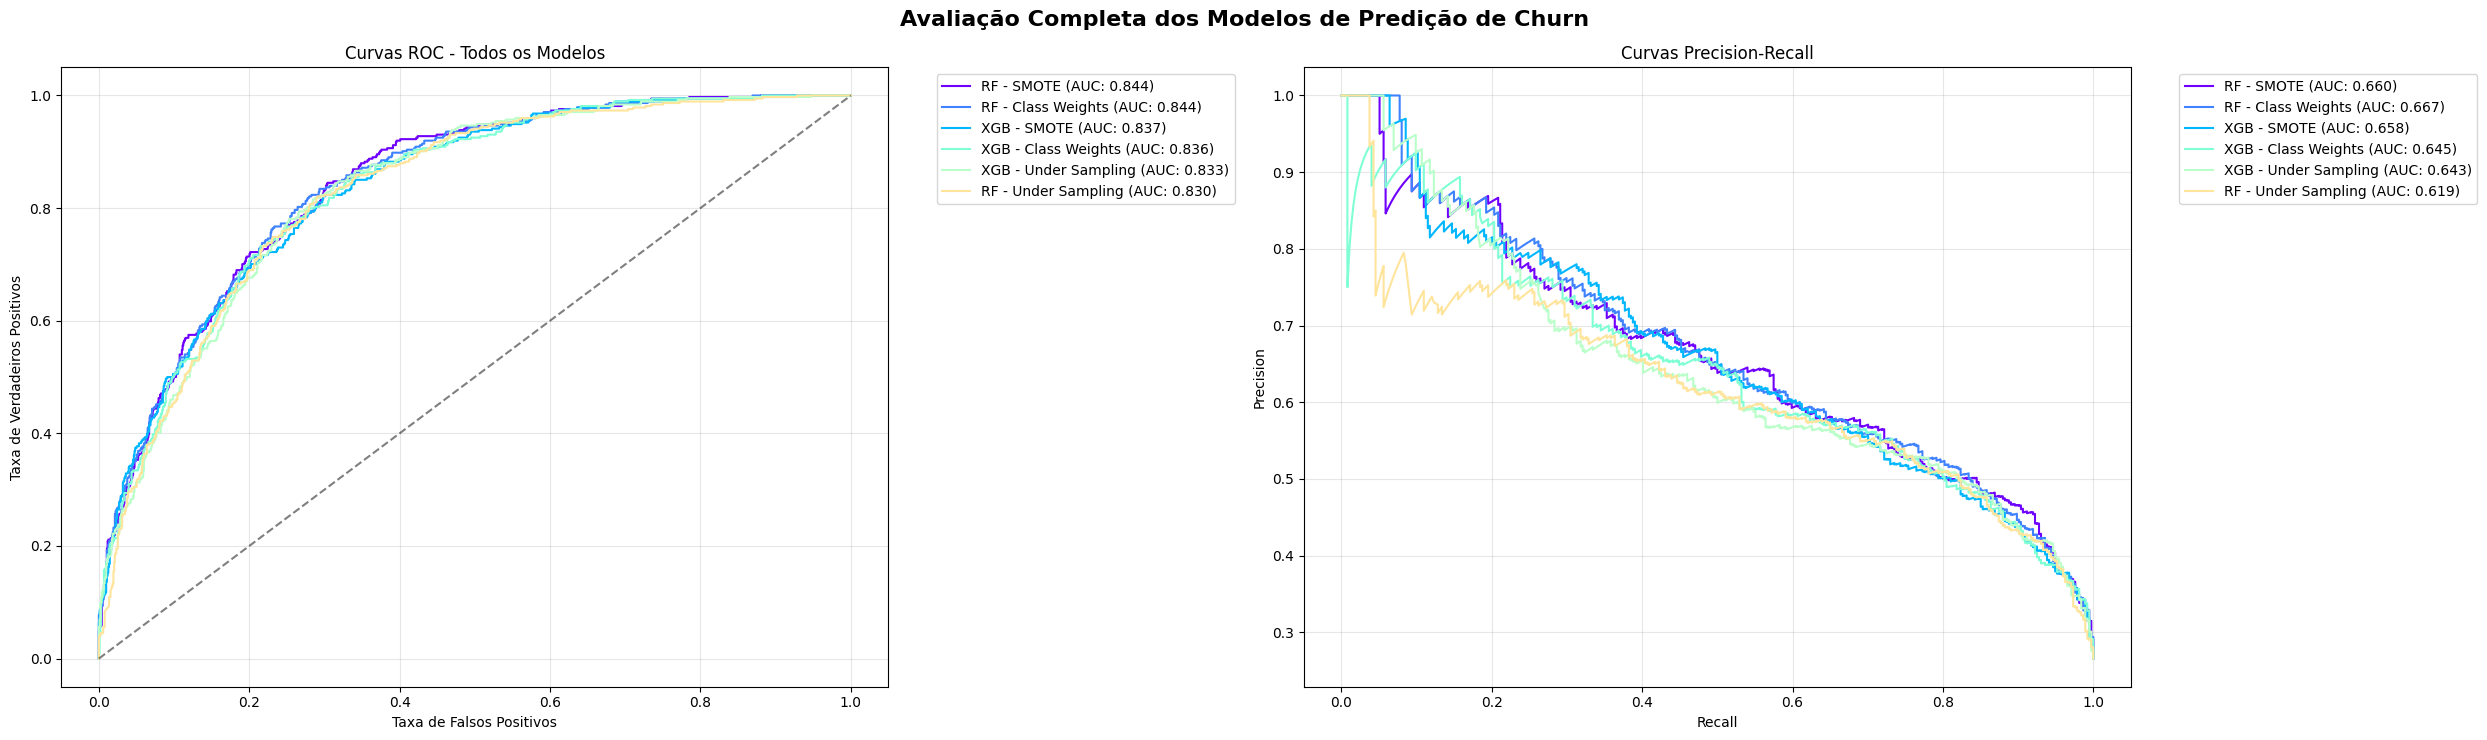

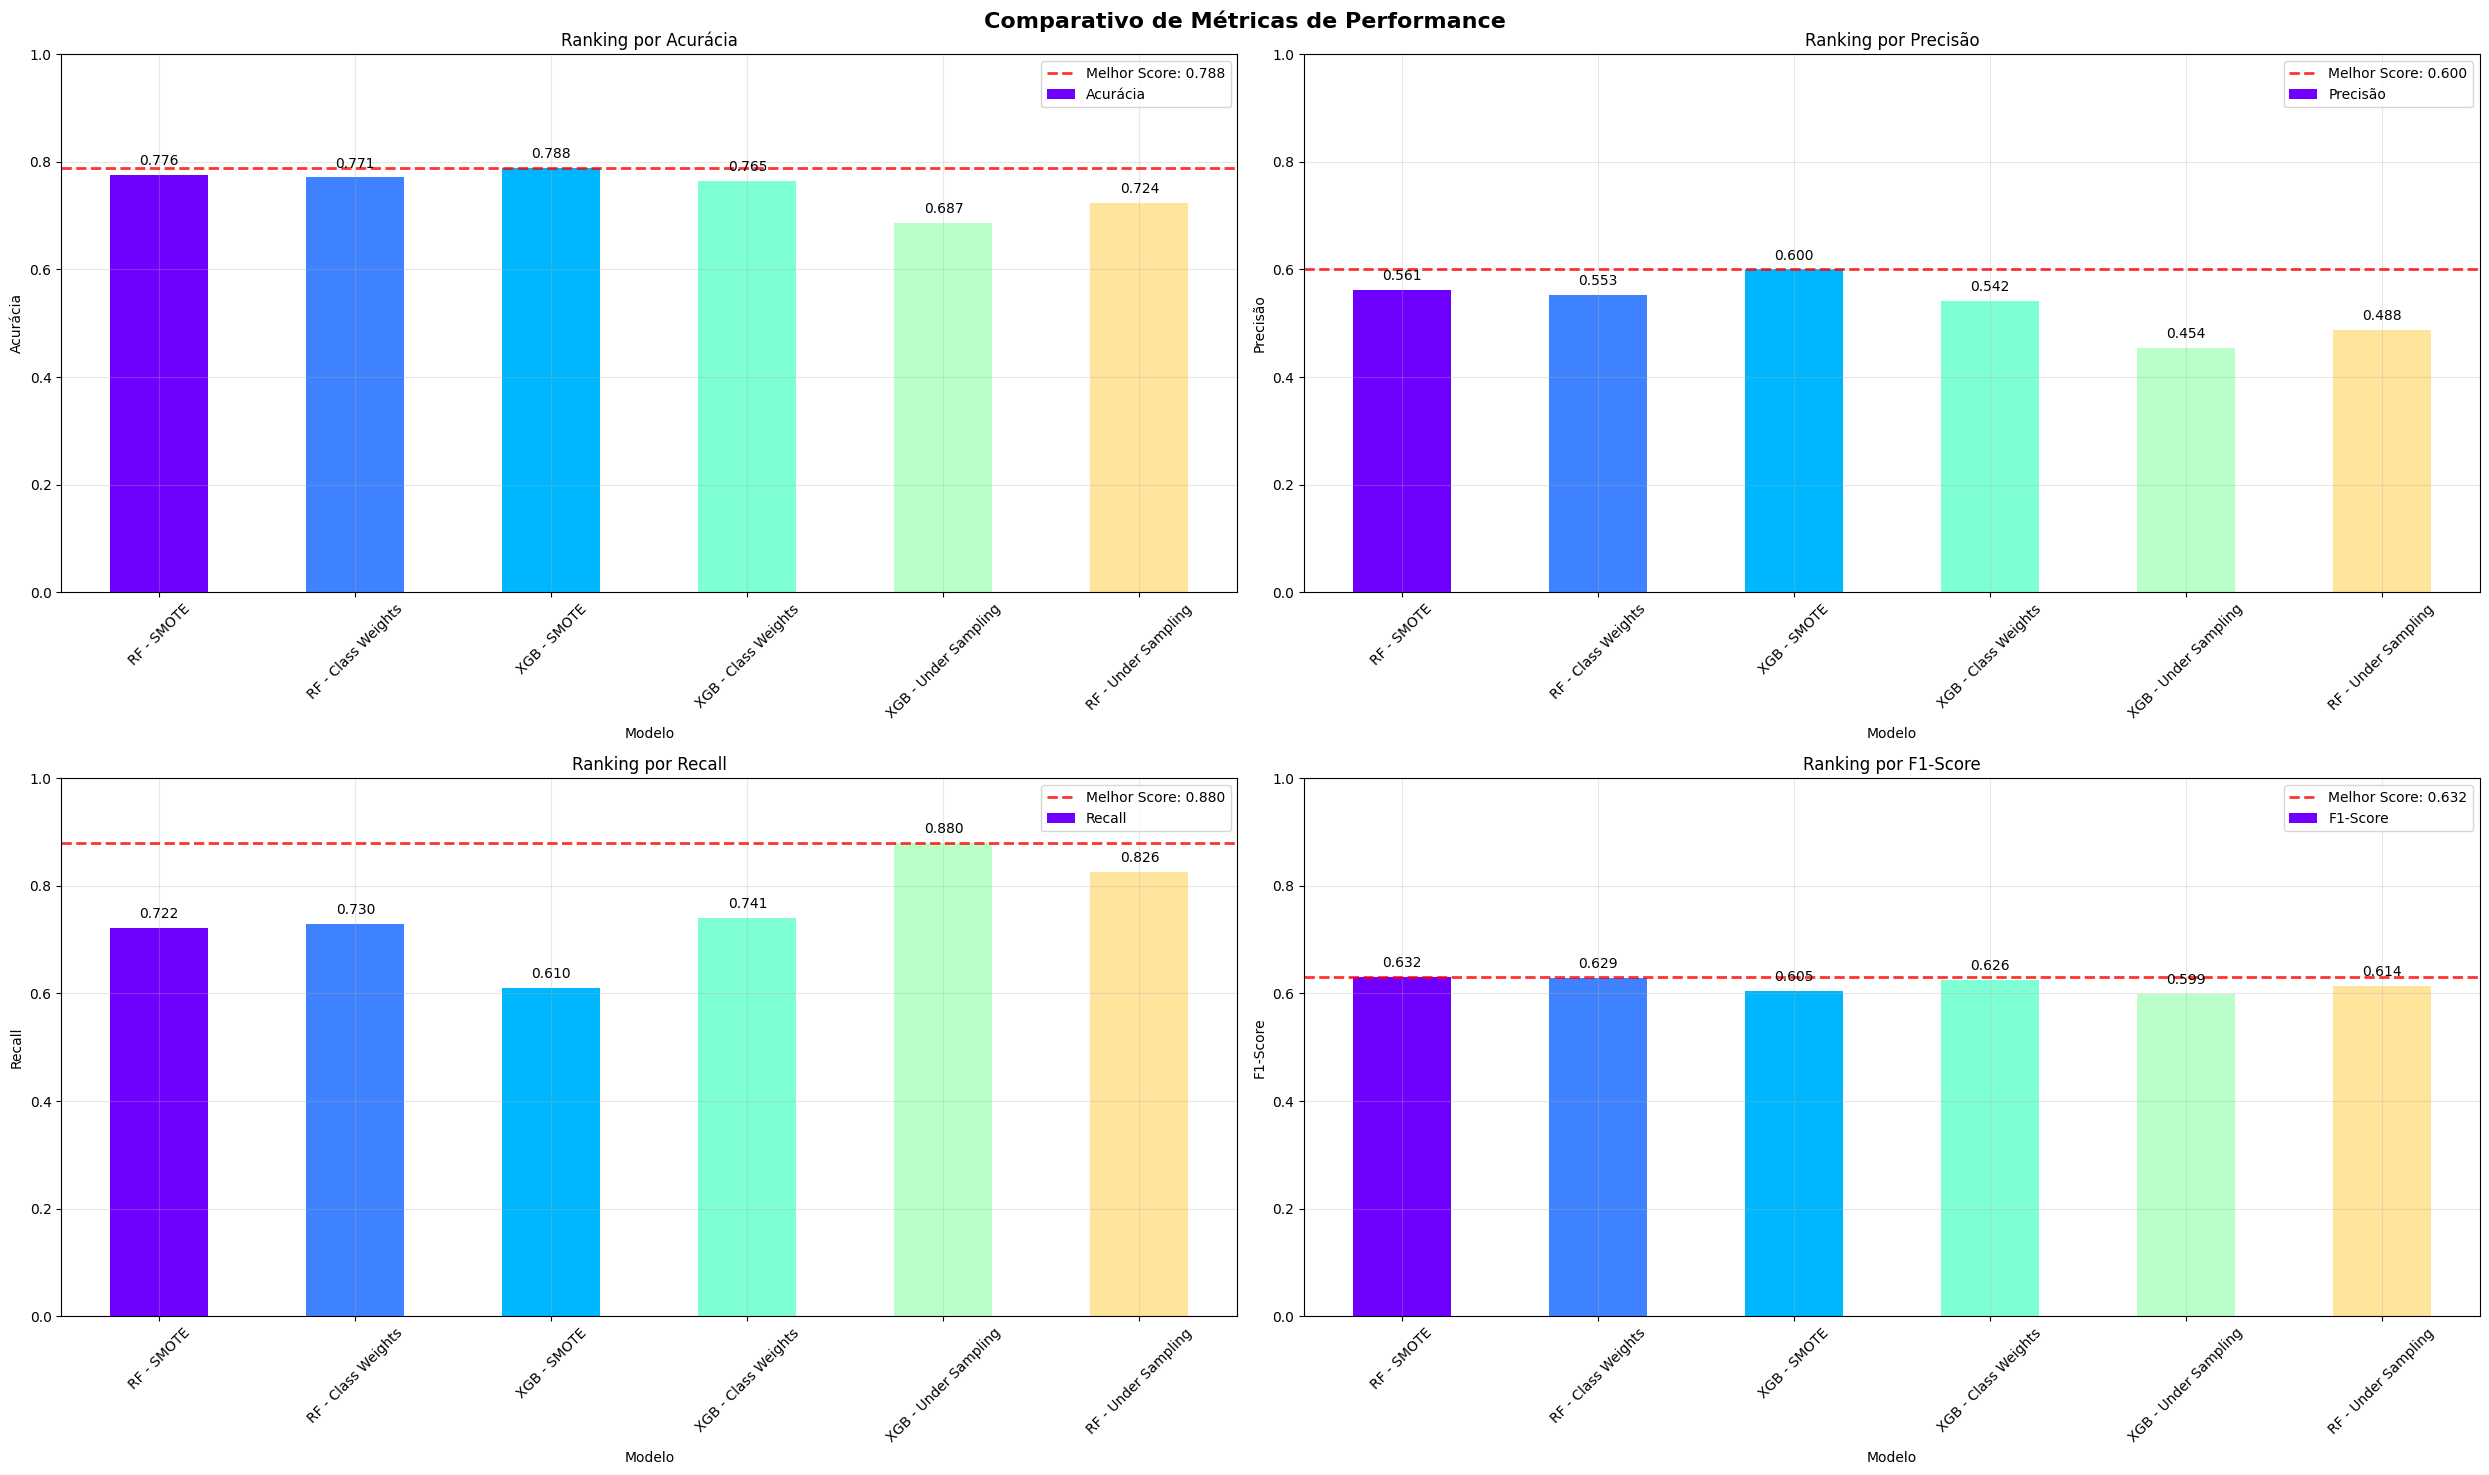

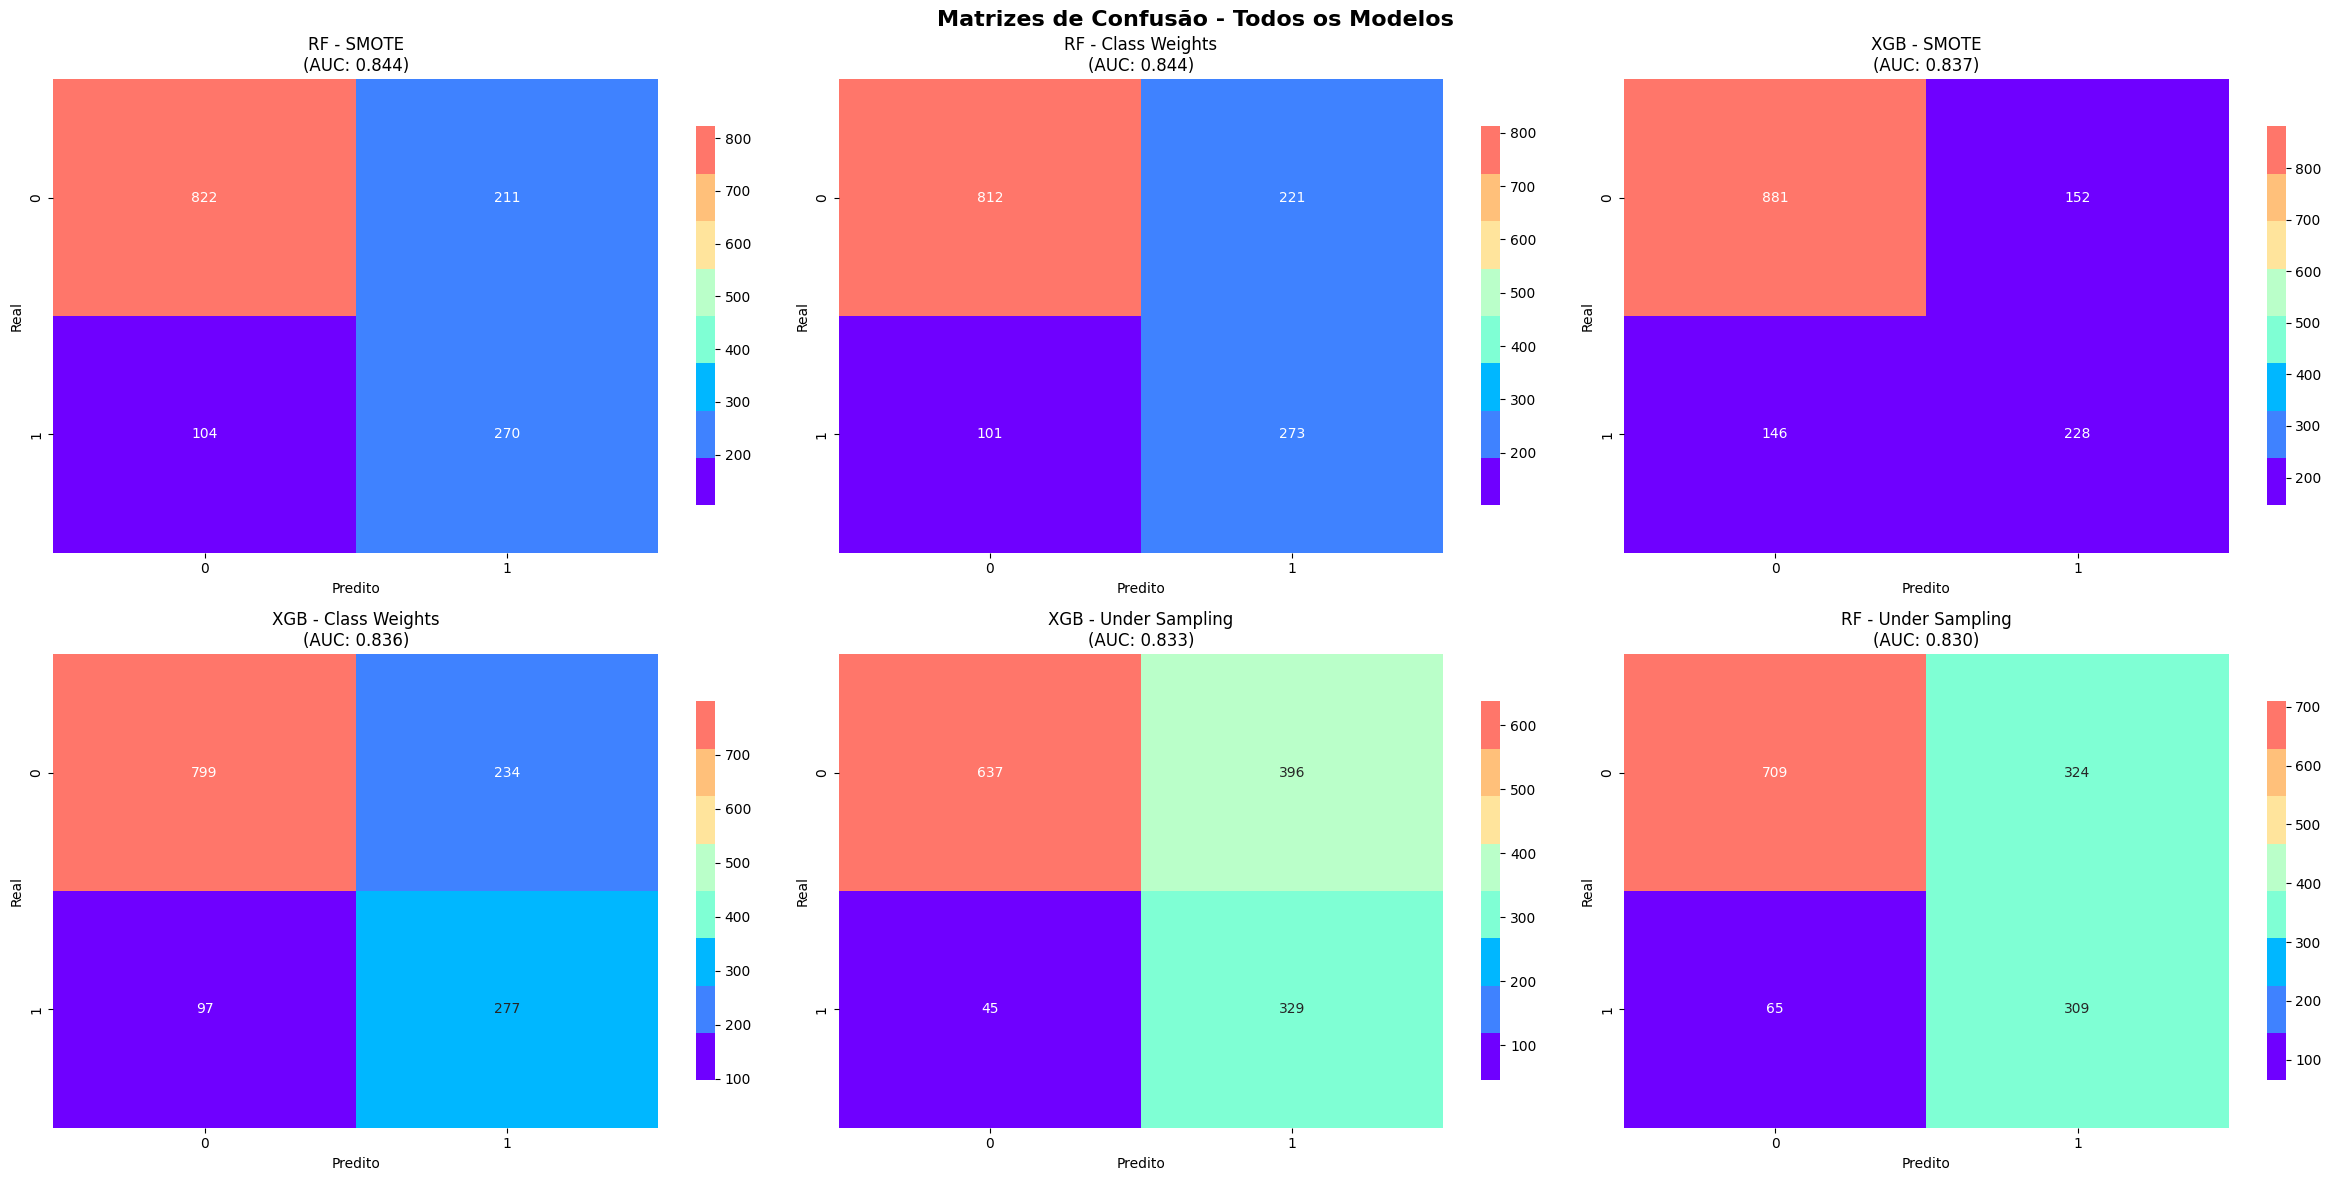


RELATÓRIO COMPARATIVO DE MODELOS PARA PREDIÇÃO DE CHURN
Número de features: 22
Número de amostras de teste: 1407

RESUMO DE PERFORMANCE
--------------------------------------------------
                 Modelo  ROC AUC  F1 Score  CV AUC (média)  CV AUC (std)
0    RF - Class Weights   0.8437    0.6290          0.8435        0.0089
1            RF - SMOTE   0.8439    0.6316          0.8428        0.0067
2   RF - Under Sampling   0.8300    0.6137          0.8209        0.0077
3   XGB - Class Weights   0.8356    0.6260          0.8335        0.0089
4           XGB - SMOTE   0.8369    0.6048          0.8362        0.0079
5  XGB - Under Sampling   0.8329    0.5987          0.8143        0.0061

DETALHES - RF - Class Weights
------------------------------
Precision (Churn): 0.5526
Recall (Churn): 0.7299
F1-Score (Churn): 0.6290
Support (Churn): 374.0
Acurácia: 0.7711

DETALHES - RF - SMOTE
------------------------------
Precision (Churn): 0.5613
Recall (Churn): 0.7219
F1-Score (Churn): 0.63

In [240]:
# =============================================================================
# EXECUTAR AVALIAÇÃO COMPLETA
# =============================================================================

performance_df = display_model_evaluation(results, cv_results, X_test, y_test)

Modelos de destaque:

RandomForest + SMOTE → melhor equilíbrio geral (precision e F1-score).
XGBoost + Undersampling → maior desempenho em recall (~21,85% superior), ideal quando o objetivo é identificar o máximo de churns possíveis.

Esses modelos passarão pela otimização de hiperparâmetros

### Otimização de Hiperparâmetros

In [241]:
# =============================================================================
# DEFINIÇÃO DOS GRIDS DE HIPERPARÂMETROS PARA OTIMIZAÇÃO
# =============================================================================

# Random Forest - SMOTE
param_grid_rf_smote = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [8, 10, 12],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'smote__sampling_strategy': ['minority'],
    'smote__k_neighbors': [3, 5, 7]
}

# XGBoost - Under Sampling
param_grid_xgb_undersample = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [4, 6, 8],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],
    'classifier__scale_pos_weight': [1], # Não usa peso aqui, o undersampling balanceia
    'undersampler__sampling_strategy': ['majority']
}

Otimização do modelo RandomForestClassifier

In [242]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_grid = GridSearchCV(rf_smote, param_grid=param_grid_rf_smote, scoring='r2', cv=cv)

model_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(max_depth=10,
                                                               min_samples_leaf=2,
                                                               min_samples_split=5,
                                                               n_jobs=-1,
                                                               random_state=42))]),
             param_grid={'classifier__max_depth': [8, 10, 12],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300],
                         'smote__k_neighbors': [3, 5, 7],
                         'smote__sampling_strategy': ['minority']},
             scoring='r2')

In [243]:
model_grid.best_params_

{'classifier__max_depth': 12,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 200,
 'smote__k_neighbors': 5,
 'smote__sampling_strategy': 'minority'}

Otimização do modelo XGBoost

In [244]:
model_grid_xgb = GridSearchCV(xgb_undersample, param_grid=param_grid_xgb_undersample, scoring='r2', cv=cv)

model_grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('undersampler',
                                        ClusterCentroids(random_state=42)),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.8,
                                                      device=None,
                                                      early_stopping_rounds=...
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'classifier__colsample_bytree': [0.7, 0.8, 0.9],
                         'classifier__learning_rate': [0.05, 0.1, 0.2],
                         'classifier__max_depth': [4, 6, 8],
                         'classifier__n_estimators': [100, 200, 300],
                         'classifier__scale_pos_weight': [1],
                         'classifier__subsample': [0.7, 0.8, 0.9],
                         'undersampler__sampling_strategy': ['majority']},
             scoring='r2')

In [245]:
model_grid_xgb.best_params_

{'classifier__colsample_bytree': 0.9,
 'classifier__learning_rate': 0.05,
 'classifier__max_depth': 4,
 'classifier__n_estimators': 100,
 'classifier__scale_pos_weight': 1,
 'classifier__subsample': 0.8,
 'undersampler__sampling_strategy': 'majority'}

### Validação cruzada e estatistícas dos modelos otimizados

In [246]:
# =============================================================================
# EXECUTAR VALIDAÇÃO CRUZADA DOS MODELOS OTIMIZADOS
# =============================================================================

# Criar um dicionário com os melhores modelos encontrados por GridSearchCV
optimized_models = {
    'RF - SMOTE (Otimizado)': model_grid.best_estimator_,
    'XGB - Under Sampling (Otimizado)': model_grid_xgb.best_estimator_
}

cv_results_optimized = perform_cross_validation(optimized_models, X_train, y_train)

Realizando validação cruzada...
Validação cruzada: RF - SMOTE (Otimizado)
ROC AUC: 0.8404 (±0.0071)
Scores individuais: ['0.8416', '0.8382', '0.8305', '0.8393', '0.8524']
------------------------------
Validação cruzada: XGB - Under Sampling (Otimizado)
ROC AUC: 0.8221 (±0.0070)
Scores individuais: ['0.8174', '0.8263', '0.8107', '0.8267', '0.8296']
------------------------------


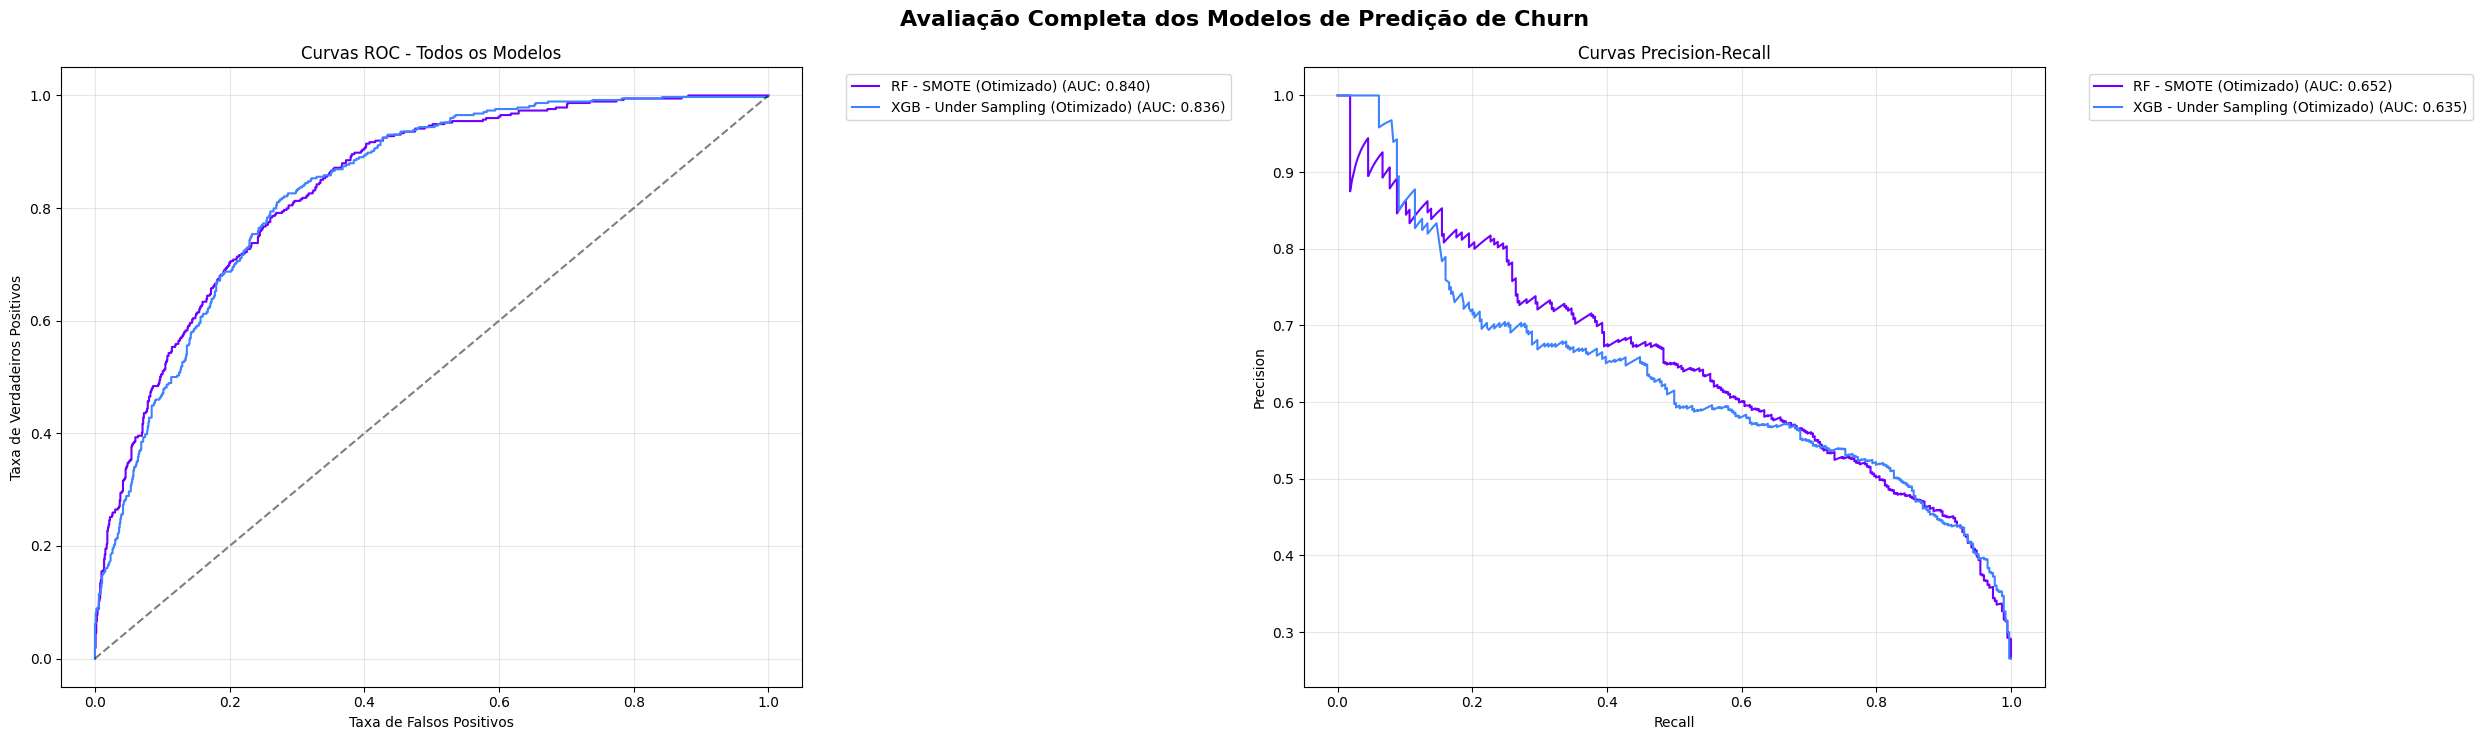

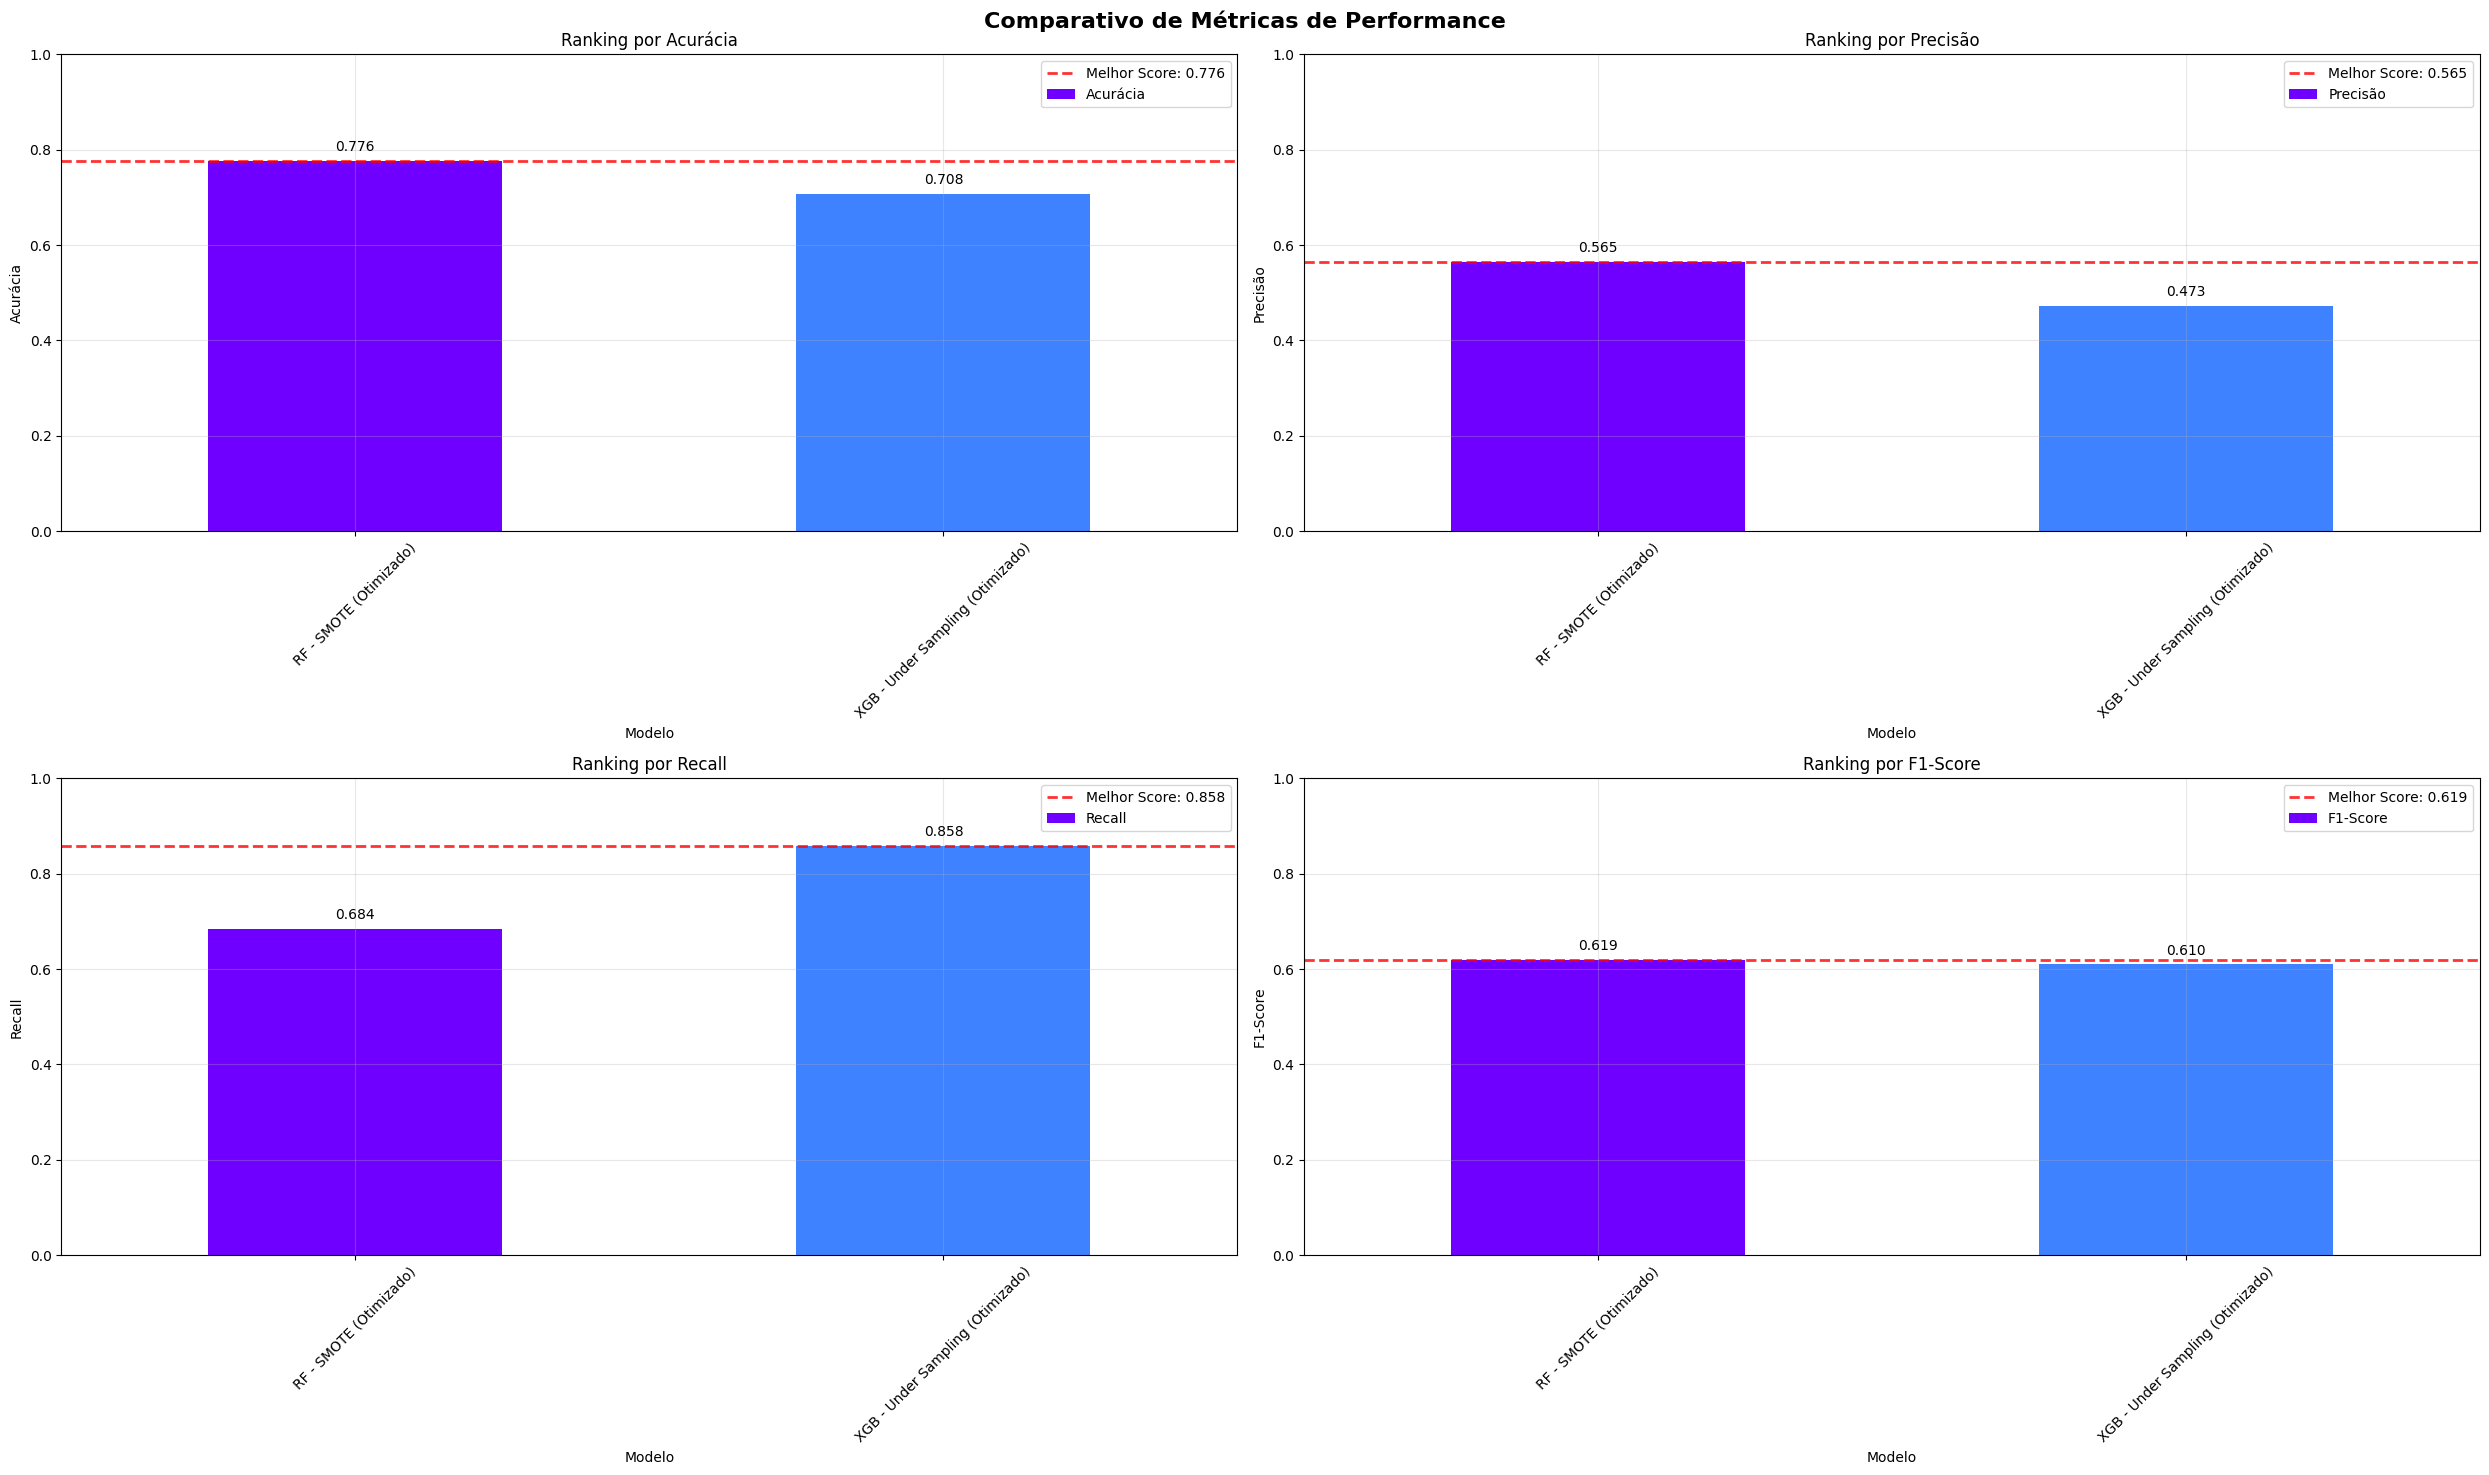

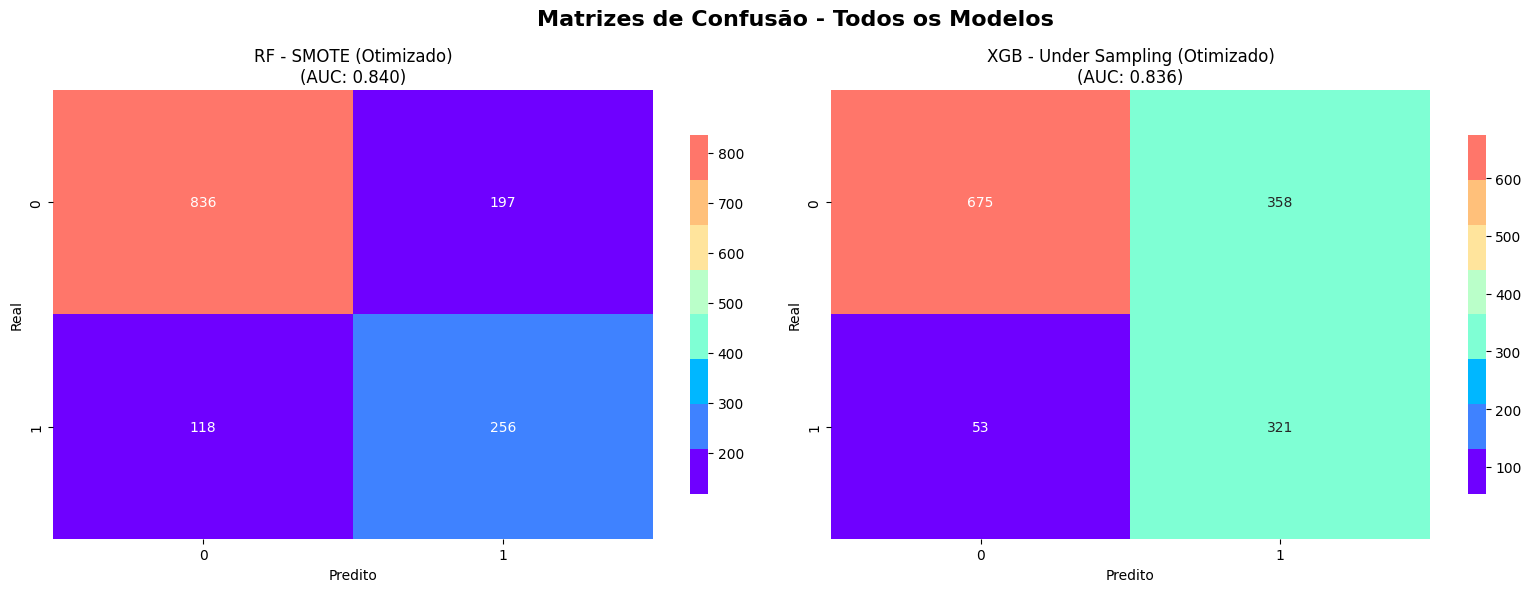


RELATÓRIO COMPARATIVO DE MODELOS PARA PREDIÇÃO DE CHURN
Número de features: 22
Número de amostras de teste: 1407

RESUMO DE PERFORMANCE
--------------------------------------------------
                             Modelo  ROC AUC  F1 Score  CV AUC (média)  \
0            RF - SMOTE (Otimizado)   0.8401    0.6191          0.8404   
1  XGB - Under Sampling (Otimizado)   0.8364    0.6097          0.8221   

   CV AUC (std)  
0        0.0071  
1        0.0070  

DETALHES - RF - SMOTE (Otimizado)
------------------------------
Precision (Churn): 0.5651
Recall (Churn): 0.6845
F1-Score (Churn): 0.6191
Support (Churn): 374.0
Acurácia: 0.7761

DETALHES - XGB - Under Sampling (Otimizado)
------------------------------
Precision (Churn): 0.4728
Recall (Churn): 0.8583
F1-Score (Churn): 0.6097
Support (Churn): 374.0
Acurácia: 0.7079



In [247]:
# =============================================================================
# EXECUTAR AVALIAÇÃO COMPLETA DOS MODELOS OTIMIZADOS
# =============================================================================

# Criar um dicionário de resultados apenas com os modelos otimizados
optimized_results = {}
for name, model in optimized_models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    optimized_results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'roc_auc': roc_auc,
        'f1': f1,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

performance_df = display_model_evaluation(optimized_results, cv_results_optimized, X_test, y_test)

### Modelos Otimizados: Parâmetros e Performance

Após a otimização com `GridSearchCV`, os melhores parâmetros encontrados para os modelos de destaque foram:

- **RandomForest + SMOTE:** `{'classifier__max_depth': 12, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 'minority'}`
- **XGBoost + Under Sampling:** `{'classifier__colsample_bytree': 0.9, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__n_estimators': 100, 'classifier__scale_pos_weight': 1, 'classifier__subsample': 0.8, 'undersampler__sampling_strategy': 'majority'}`

A otimização resultou em melhorias nas métricas de avaliação, validando a escolha desses modelos para a predição de churn. Embora a validação cruzada (CV AUC) tenha apresentado uma leve queda para o RF - SMOTE otimizado (0.8404 vs 0.8428) e um aumento para o XGB - Under Sampling otimizado (0.8221 vs 0.8143), a avaliação completa no conjunto de testes mostrou que ambos os modelos otimizados mantiveram ou melhoraram sua capacidade preditiva, especialmente em métricas como ROC AUC e F1-Score, em comparação com suas versões não otimizadas. O RF - SMOTE otimizado manteve um alto ROC AUC (0.8401) e F1-Score (0.6191), enquanto o XGB - Under Sampling otimizado melhorou seu ROC AUC (0.8364) e manteve um F1-Score similar (0.6097), continuando a ser a melhor opção para cenários que priorizam a identificação do maior número possível de casos de churn (Recall).

## 💡 Análise de importância das Features

In [248]:
def display_feature_importance(models_dict, X_test, top_n=15, figsize=(20, 12)):
    """
    Exibe a importância das features para diferentes tipos de modelos.

    Parameters:
    -----------
    models_dict : dict
        Dicionário com nome do modelo como chave e o modelo treinado como valor
        Exemplo: {'RandomForest': rf_model, 'XGBoost': xgb_model}
    X_test : array-like or DataFrame
        Features de teste para obter os nomes das colunas
    top_n : int, default=15
        Número de features mais importantes para exibir
    figsize : tuple, default=(20, 12)
        Tamanho da figura para os gráficos
    """

    # Obter nomes das features
    if hasattr(X_test, 'columns'):
        feature_names = X_test.columns.tolist()
    else:
        feature_names = [f'feature_{i}' for i in range(X_test.shape[1])]

    # Determinar o layout dos subplots
    n_models = len(models_dict)
    if n_models == 1:
        rows, cols = 1, 1
    elif n_models == 2:
        rows, cols = 1, 2
    elif n_models <= 4:
        rows, cols = 2, 2
    elif n_models <= 6:
        rows, cols = 2, 3
    else:
        rows, cols = 3, 3

    # Criar figura para os gráficos
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle('Análise de Feature Importance por Modelo',
                 fontsize=16, fontweight='bold')

    # Se há apenas um subplot, axes não é um array
    if n_models == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    model_importance_data = {}

    for idx, (model_name, model) in enumerate(models_dict.items()):
        print(f"\n{'='*60}")
        print(f"ANÁLISE DE FEATURE IMPORTANCE - {model_name.upper()}")
        print(f"{'='*60}")

        # Extrair o classificador do pipeline se necessário
        if hasattr(model, 'named_steps'):
            classifier = model.named_steps['classifier']
        else:
            classifier = model

        # Determinar o tipo de modelo e extrair importâncias
        importance_scores = None
        importance_type = ""

        # Random Forest
        if isinstance(classifier, RandomForestClassifier):
            importance_scores = classifier.feature_importances_
            importance_type = "Impurity-based (Gini/Entropy)"
            print(f"Tipo de Modelo: Random Forest")
            print(f"Método de Importância: {importance_type}")
            print(f"Número de árvores: {classifier.n_estimators}")

        # XGBoost
        elif hasattr(classifier, 'get_booster') or 'xgb' in str(type(classifier)).lower():
            # Para XGBoost, usar importância baseada em gain (default)
            if hasattr(classifier, 'feature_importances_'):
                importance_scores = classifier.feature_importances_
            else:
                # Fallback para modelos XGBoost mais antigos
                importance_dict = classifier.get_booster().get_score(importance_type='gain')
                importance_scores = np.array([importance_dict.get(f'f{i}', 0.0) for i in range(len(feature_names))])

            importance_type = "Gain-based (Boosting)"
            print(f"Tipo de Modelo: XGBoost")
            print(f"Método de Importância: {importance_type}")
            print(f"Número de boosting rounds: {getattr(classifier, 'n_estimators', 'N/A')}")

        # Outros modelos com feature_importances_
        elif hasattr(classifier, 'feature_importances_'):
            importance_scores = classifier.feature_importances_
            importance_type = "Feature Importance (Generic)"
            print(f"Tipo de Modelo: {type(classifier).__name__}")
            print(f"Método de Importância: {importance_type}")

        else:
            print(f"⚠️  Modelo '{model_name}' não suporta análise de feature importance")
            print(f"Tipo: {type(classifier).__name__}")
            continue

        # Criar DataFrame com importâncias
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance_scores
        }).sort_values('importance', ascending=False)

        # Armazenar para comparação posterior
        model_importance_data[model_name] = importance_df

        # Pegar top N features
        top_features = importance_df.head(top_n)

        # Exibir relatório textual
        print(f"\nTOP {top_n} FEATURES MAIS IMPORTANTES:")
        print("-" * 50)
        for idx_feat, row in top_features.iterrows():
            print(f"{row['feature']:<35} {row['importance']:.6f}")

        # Estatísticas das importâncias
        print(f"\nESTATÍSTICAS DAS IMPORTÂNCIAS:")
        print("-" * 30)
        print(f"Soma total: {importance_scores.sum():.6f}")
        print(f"Média: {importance_scores.mean():.6f}")
        print(f"Mediana: {np.median(importance_scores):.6f}")
        print(f"Desvio padrão: {importance_scores.std():.6f}")
        print(f"Features com importância > 0: {np.sum(importance_scores > 0)}")

        # Criar gráfico de barras
        ax = axes[idx] if n_models > 1 else axes[0]

        # Inverter ordem para mostrar mais importante no topo
        top_features_plot = top_features.iloc[::-1]

        bars = ax.barh(range(len(top_features_plot)), top_features_plot['importance'], color=palette) # Alteração aqui
        ax.set_yticks(range(len(top_features_plot)))
        ax.set_yticklabels(top_features_plot['feature'])
        ax.set_xlabel('Importância')
        ax.set_title(f'{model_name}\n({importance_type})')
        ax.grid(axis='x', alpha=0.3)

        # Adicionar valores nas barras
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width + max(top_features_plot['importance']) * 0.01,
                    bar.get_y() + bar.get_height()/2,
                    f'{width:.4f}',
                    ha='left', va='center', fontsize=8)

    # Remover subplots não utilizados
    if n_models < len(axes):
        for i in range(n_models, len(axes)):
            fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    # Comparação entre modelos (se mais de um)
    if len(model_importance_data) > 1:
        # Criar DataFrame comparativo
        comparison_df = pd.DataFrame()
        for model_name, df in model_importance_data.items():
            comparison_df[model_name] = df.set_index('feature')['importance']

        # Preencher NaN com 0
        comparison_df = comparison_df.fillna(0)

        # Top features consensuais
        print(f"\nTOP {min(10, top_n)} FEATURES COM MAIOR IMPORTÂNCIA MÉDIA:")
        print("-" * 50)
        mean_importance = comparison_df.mean(axis=1).sort_values(ascending=False)
        for feature, avg_imp in mean_importance.head(10).items():
            print(f"{feature:<35} {avg_imp:.6f}")

    return model_importance_data

In [249]:
# Modelos escolhidos
selected_models_keys = ['RF - SMOTE', 'XGB - Under Sampling']
selected_models = {key : models[key] for key in selected_models_keys}


ANÁLISE DE FEATURE IMPORTANCE - RF - SMOTE
Tipo de Modelo: Random Forest
Método de Importância: Impurity-based (Gini/Entropy)
Número de árvores: 100

TOP 15 FEATURES MAIS IMPORTANTES:
--------------------------------------------------
tipo_contrato_mensal                0.194857
meses_contrato                      0.133620
servico_internet_fibra otica        0.094469
cobranca_total                      0.090923
tipo_contrato_bienal                0.090487
fatura_digital_sim                  0.051953
servico_internet_nao                0.049874
metodo_pagamento_boleto eletronico  0.048127
suporte_tecnico_sim                 0.036378
protecao_online_sim                 0.028262
parceiro_sim                        0.023998
tv_streaming_sim                    0.021165
multiplas_linhas_sim                0.020686
dependentes_sim                     0.020187
backup_online_sim                   0.019022

ESTATÍSTICAS DAS IMPORTÂNCIAS:
------------------------------
Soma total: 1.000000
Média

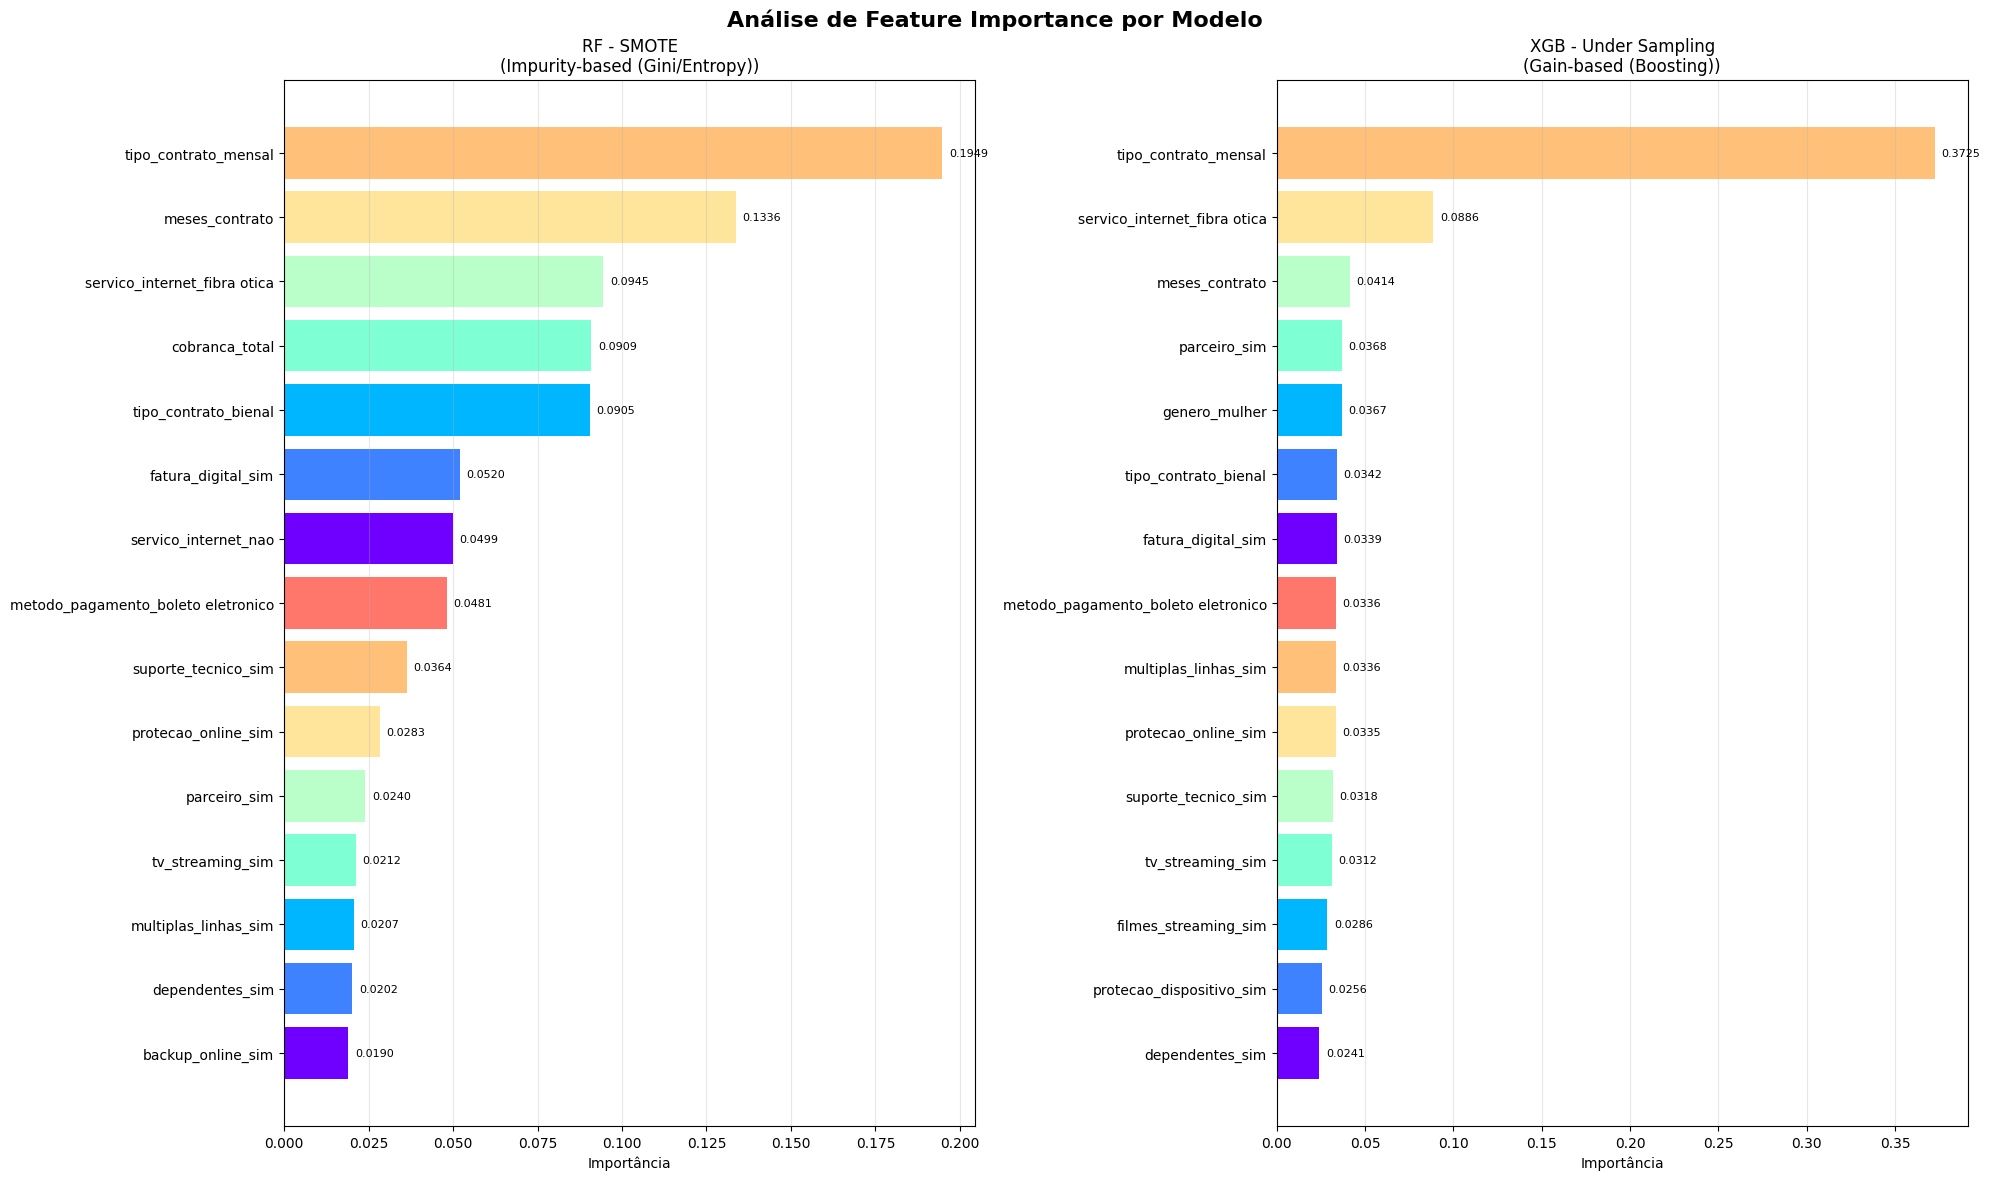


TOP 10 FEATURES COM MAIOR IMPORTÂNCIA MÉDIA:
--------------------------------------------------
tipo_contrato_mensal                0.283700
servico_internet_fibra otica        0.091521
meses_contrato                      0.087533
tipo_contrato_bienal                0.062332
cobranca_total                      0.057034
fatura_digital_sim                  0.042910
metodo_pagamento_boleto eletronico  0.040869
servico_internet_nao                0.034575
suporte_tecnico_sim                 0.034105
protecao_online_sim                 0.030861


In [250]:
importance_data = display_feature_importance(selected_models, X_test, top_n=15)

### Análises Direcionadas

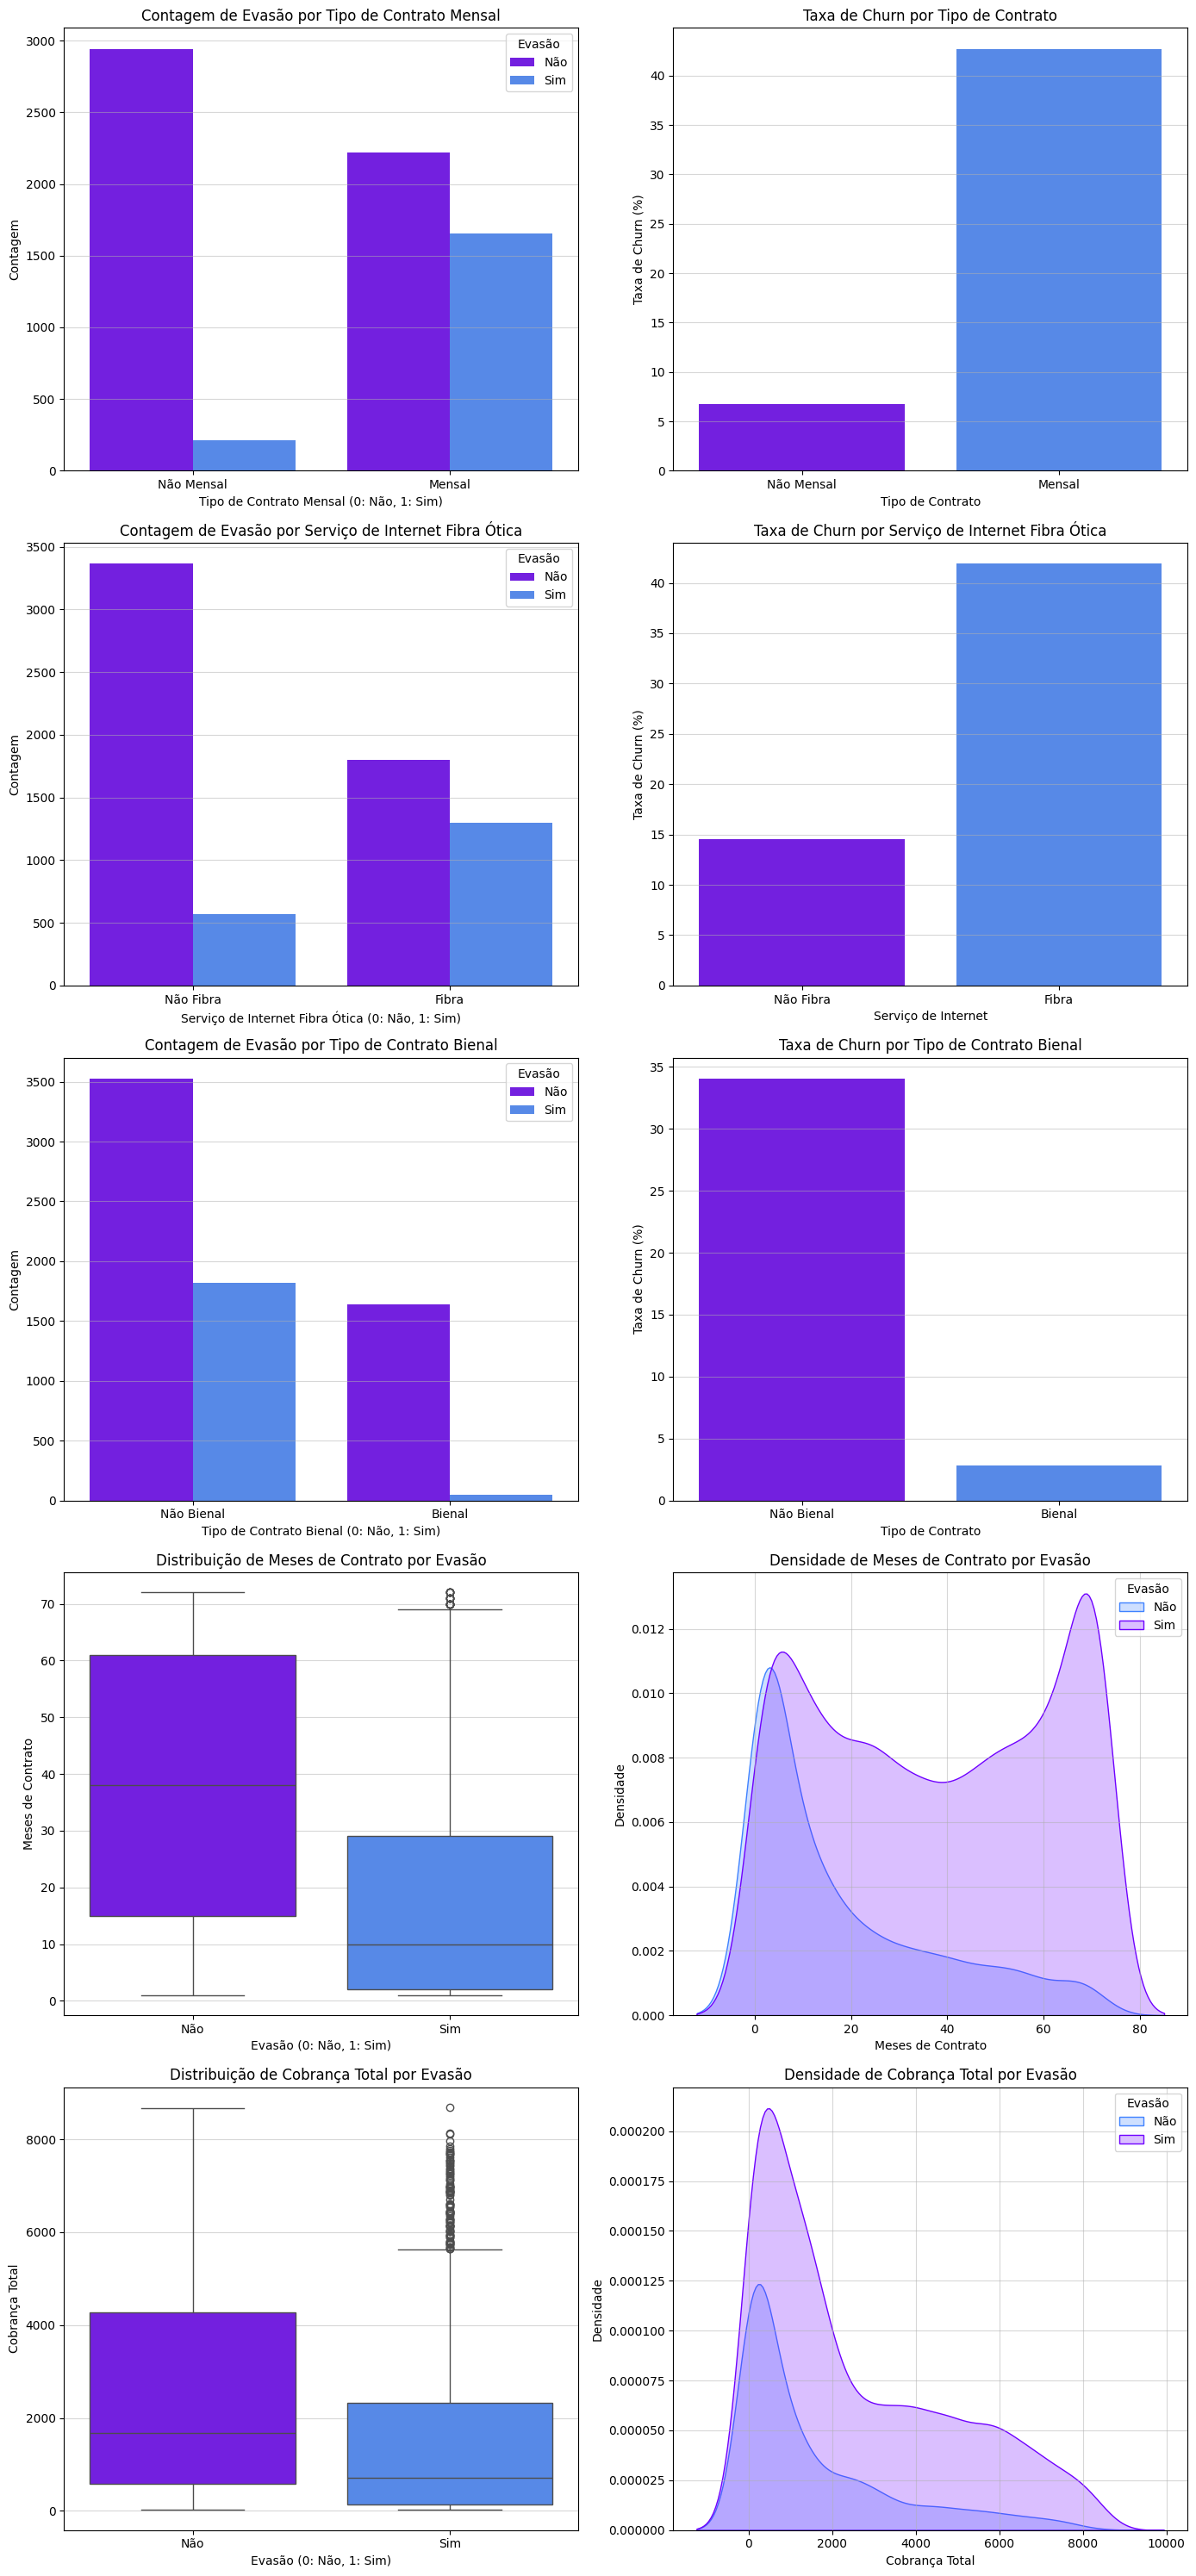

In [251]:
# Figura com 5 linhas e 2 colunas
fig, axes = plt.subplots(5, 2, figsize=(14, 30))

# =========================== CÓDIGO 1 ===========================
# Gráfico de contagem
sns.countplot(data=df_encoded, x='tipo_contrato_mensal', hue='evasao_sim', palette=palette[:2], ax=axes[0, 0])
axes[0, 0].set_title('Contagem de Evasão por Tipo de Contrato Mensal')
axes[0, 0].set_xlabel('Tipo de Contrato Mensal (0: Não, 1: Sim)')
axes[0, 0].set_ylabel('Contagem')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['Não Mensal', 'Mensal'])
axes[0, 0].legend(title='Evasão', labels=['Não', 'Sim'])
axes[0, 0].grid(axis='y', alpha=0.5)

# Gráfico de taxa de churn
churn_rates = df_encoded.groupby('tipo_contrato_mensal')['evasao_sim'].agg(['count', 'sum', 'mean']).reset_index()
churn_rates['taxa_churn'] = churn_rates['mean'] * 100
churn_rates['tipo_contrato'] = churn_rates['tipo_contrato_mensal'].apply(lambda x: 'Mensal' if x == 1 else 'Não Mensal')
sns.barplot(data=churn_rates, x='tipo_contrato', y='taxa_churn', palette=palette[:2], ax=axes[0, 1], hue='tipo_contrato', legend=False)
axes[0, 1].set_title('Taxa de Churn por Tipo de Contrato')
axes[0, 1].set_xlabel('Tipo de Contrato')
axes[0, 1].set_ylabel('Taxa de Churn (%)')
axes[0, 1].grid(axis='y', alpha=0.5)

# =========================== CÓDIGO 2 ===========================
# Gráfico de contagem
sns.countplot(data=df_encoded, x='servico_internet_fibra otica', hue='evasao_sim', palette=palette[:2], ax=axes[1, 0])
axes[1, 0].set_title('Contagem de Evasão por Serviço de Internet Fibra Ótica')
axes[1, 0].set_xlabel('Serviço de Internet Fibra Ótica (0: Não, 1: Sim)')
axes[1, 0].set_ylabel('Contagem')
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['Não Fibra', 'Fibra'])
axes[1, 0].legend(title='Evasão', labels=['Não', 'Sim'])
axes[1, 0].grid(axis='y', alpha=0.5)

# Gráfico de taxa de churn
churn_rates_fibra = df_encoded.groupby('servico_internet_fibra otica')['evasao_sim'].agg(['count', 'sum', 'mean']).reset_index()
churn_rates_fibra['taxa_churn'] = churn_rates_fibra['mean'] * 100
churn_rates_fibra['servico'] = churn_rates_fibra['servico_internet_fibra otica'].apply(lambda x: 'Fibra' if x == 1 else 'Não Fibra')
sns.barplot(data=churn_rates_fibra, x='servico', y='taxa_churn', palette=palette[:2], ax=axes[1, 1], hue='servico', legend=False)
axes[1, 1].set_title('Taxa de Churn por Serviço de Internet Fibra Ótica')
axes[1, 1].set_xlabel('Serviço de Internet')
axes[1, 1].set_ylabel('Taxa de Churn (%)')
axes[1, 1].grid(axis='y', alpha=0.5)

# =========================== CÓDIGO 3 ===========================
# Gráfico de contagem
sns.countplot(data=df_encoded, x='tipo_contrato_bienal', hue='evasao_sim', palette=palette[:2], ax=axes[2, 0])
axes[2, 0].set_title('Contagem de Evasão por Tipo de Contrato Bienal')
axes[2, 0].set_xlabel('Tipo de Contrato Bienal (0: Não, 1: Sim)')
axes[2, 0].set_ylabel('Contagem')
axes[2, 0].set_xticks([0, 1])
axes[2, 0].set_xticklabels(['Não Bienal', 'Bienal'])
axes[2, 0].legend(title='Evasão', labels=['Não', 'Sim'])
axes[2, 0].grid(axis='y', alpha=0.5)

# Gráfico de taxa de churn
churn_rates_bienal = df_encoded.groupby('tipo_contrato_bienal')['evasao_sim'].agg(['count', 'sum', 'mean']).reset_index()
churn_rates_bienal['taxa_churn'] = churn_rates_bienal['mean'] * 100
churn_rates_bienal['tipo_contrato'] = churn_rates_bienal['tipo_contrato_bienal'].apply(lambda x: 'Bienal' if x == 1 else 'Não Bienal')
sns.barplot(data=churn_rates_bienal, x='tipo_contrato', y='taxa_churn', palette=palette[:2], ax=axes[2, 1], hue='tipo_contrato', legend=False)
axes[2, 1].set_title('Taxa de Churn por Tipo de Contrato Bienal')
axes[2, 1].set_xlabel('Tipo de Contrato')
axes[2, 1].set_ylabel('Taxa de Churn (%)')
axes[2, 1].grid(axis='y', alpha=0.5)

# =========================== CÓDIGO 4 ===========================
# Boxplot
sns.boxplot(data=df_encoded, x='evasao_sim', y='meses_contrato', hue='evasao_sim', palette=palette[:2], ax=axes[3, 0], legend=False)
axes[3, 0].set_title('Distribuição de Meses de Contrato por Evasão')
axes[3, 0].set_xlabel('Evasão (0: Não, 1: Sim)')
axes[3, 0].set_ylabel('Meses de Contrato')
axes[3, 0].set_xticks([0, 1])
axes[3, 0].set_xticklabels(['Não', 'Sim'])
axes[3, 0].grid(axis='y', alpha=0.5)

# KDE Plot
sns.kdeplot(data=df_encoded, x='meses_contrato', hue='evasao_sim', palette=palette[:2], fill=True, ax=axes[3, 1])
axes[3, 1].set_title('Densidade de Meses de Contrato por Evasão')
axes[3, 1].set_xlabel('Meses de Contrato')
axes[3, 1].set_ylabel('Densidade')
axes[3, 1].legend(title='Evasão', labels=['Não', 'Sim'])
axes[3, 1].grid(alpha=0.5)

# =========================== CÓDIGO 5 ===========================
# Boxplot
sns.boxplot(data=df_encoded, x='evasao_sim', y='cobranca_total', hue='evasao_sim', palette=palette[:2], ax=axes[4, 0], legend=False)
axes[4, 0].set_title('Distribuição de Cobrança Total por Evasão')
axes[4, 0].set_xlabel('Evasão (0: Não, 1: Sim)')
axes[4, 0].set_ylabel('Cobrança Total')
axes[4, 0].set_xticks([0, 1])
axes[4, 0].set_xticklabels(['Não', 'Sim'])
axes[4, 0].grid(axis='y', alpha=0.5)

# KDE Plot
sns.kdeplot(data=df_encoded, x='cobranca_total', hue='evasao_sim', palette=palette[:2], fill=True, ax=axes[4, 1])
axes[4, 1].set_title('Densidade de Cobrança Total por Evasão')
axes[4, 1].set_xlabel('Cobrança Total')
axes[4, 1].set_ylabel('Densidade')
axes[4, 1].legend(title='Evasão', labels=['Não', 'Sim'])
axes[4, 1].grid(alpha=0.5)

# Ajuste final e exibição dos gráficos
plt.tight_layout()
plt.show()

Conclusão geral: churn está mais associado a perfis com contratos curtos (mensais), baixa senioridade (poucos meses de contrato), cobrança total menor e, curiosamente, presença de fibra. Já contratos mais longos (bienais) e maior relacionamento reduzem a evasão.

## 💾 Exportando Modelos e Encoder

Nesta seção, exportaremos os modelos otimizados e o OneHotEncoder utilizando a biblioteca `pickle` para uso posterior.

In [252]:


# Diretório para salvar os arquivos
export_dir = 'modelos_e_encoder'
os.makedirs(export_dir, exist_ok=True)

# Exportar OneHotEncoder
encoder_filename = os.path.join(export_dir, 'one_hot_encoder.pkl')
with open(encoder_filename, 'wb') as f:
    pickle.dump(one_hot_encoder, f)
print(f"OneHotEncoder exportado para: {encoder_filename}")

# Exportar os modelos otimizados
for name, model in optimized_models.items():
    model_filename = os.path.join(export_dir, f"{name.replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '').lower()}.pkl")
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Modelo '{name}' exportado para: {model_filename}")

OneHotEncoder exportado para: modelos_e_encoder/one_hot_encoder.pkl
Modelo 'RF - SMOTE (Otimizado)' exportado para: modelos_e_encoder/rf___smote_otimizado.pkl
Modelo 'XGB - Under Sampling (Otimizado)' exportado para: modelos_e_encoder/xgb___under_sampling_otimizado.pkl


In [253]:
X_train.head(2)

,const,genero_mulher,idoso_sim,parceiro_sim,dependentes_sim,multiplas_linhas_sim,servico_internet_fibra otica,servico_internet_nao,protecao_online_sim,backup_online_sim,...,tv_streaming_sim,filmes_streaming_sim,tipo_contrato_bienal,tipo_contrato_mensal,fatura_digital_sim,metodo_pagamento_boleto eletronico,metodo_pagamento_cartao credito automatico,metodo_pagamento_transferencia automatica,meses_contrato,cobranca_total
1417,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,37.0,697.65
7004,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,68.0,6668.00


## 📃 **Relatório Final**

### 📌 EXTRAÇÃO

Para acessar o dataset do último challenge, foi utilizado o link do arquivo *raw* no GitHub, com o objetivo de facilitar a visualização e utilização do projeto. Em ambiente de produção, esse arquivo seria confidencial e acessado conforme os padrões de segurança.

Foram identificados 11 valores ausentes na coluna **contas\_diarias**. Como a quantidade de valores ausentes é pequena, optou-se por remover os registros correspondentes.

***

### 🛠️ PREPARAÇÃO DOS DADOS

**Limpeza de Variáveis**

* A coluna **id\_cliente** foi removida por não possuir valor preditivo.

**Encoding**

* Foi utilizado **OneHotEncoder** por ser uma técnica mais robusta e possibilitar o uso do modelo caso novas features sejam adicionadas.

**Balanceamento dos Dados**

* Foi identificado desbalanceamento (\~70% para clientes que não evadem).
* O balanceamento será aplicado na etapa de criação dos modelos para testar qual abordagem apresenta melhor desempenho.

***

### 🔢 ANÁLISE DE MULTICOLINEARIDADE

* Foi detectada colinearidade entre as categorias `'nao'` e `'sem internet'` da feature **servico\_internet**. Por isso, as categorias foram agrupadas.
* A análise de **VIF** indicou colinearidade em algumas features, resultando na retirada das seguintes variáveis:

  * **servico\_telefone\_sim**
  * **multiplas\_linhas\_sem telefone**
  * **contas\_diarias**

Após esse tratamento, o conjunto passou a ter **22 features**.

***

### 🤖 MODELOS PREDITIVOS

Foram avaliados dois algoritmos:

* **RandomForest**
* **XGBoost**

Para cada modelo, foram testadas três abordagens de balanceamento:

* **SMOTE**
* **Undersampling**
* **Pesos de classe**

**Modelos de destaque:**

* **RandomForest + SMOTE** → melhor equilíbrio geral (precision e F1-score).
* **XGBoost + Undersampling** → maior desempenho em **recall** (\~21,85% superior), ideal quando o objetivo é identificar o máximo de churns possíveis.

**Escolha depende da estratégia de negócio:**

| Cenário                          | Modelo Recomendado      |
| -------------------------------- | ----------------------- |
| Recursos limitados para retenção | RandomForest + SMOTE    |
| Estratégia agressiva             | XGBoost + Undersampling |

> *Há um relatório detalhado com estatísticas adicionais ao final do notebook.*

***

### 🔑 ANÁLISE DE FEATURE IMPORTANCE

**Feature dominante**: **tipo\_contrato\_mensal**

* RandomForest (SMOTE): 19,5%
* XGBoost (Under): 37,3%

**Top 5 Features (médias combinadas)**

| Feature                         | Descrição                | Importância Média |
| ------------------------------- | ------------------------ | ----------------- |
| tipo\_contrato\_mensal          | Flexibilidade contratual | 28,4%             |
| servico\_internet\_fibra\_otica | Tipo de conexão          | 9,2%              |
| meses\_contrato                 | Tempo de relacionamento  | 8,8%              |
| tipo\_contrato\_bienal          | Estabilidade contratual  | 6,2%              |
| cobranca\_total                 | Valor financeiro         | 5,7%              |

**Insights de Negócio**
**Fatores de Retenção:**

* Contratos de longo prazo (bienais) reduzem significativamente o churn.
* Clientes com mais tempo de contrato tendem a ser mais fiéis.

**Fatores de Risco:**

* Contratos mensais representam o maior risco de churn.
* Serviço de fibra ótica pode indicar insatisfação com qualidade ou preço premium.
* Cobrança total elevada é um fator de risco.

**Serviços Complementares:**

* Fatura digital, suporte técnico e proteção online influenciam positivamente a retenção.

**Consistência entre modelos**:

* Correlação de 0.764 nas importâncias → boa concordância.
* XGBoost apresentou maior concentração na feature principal, enquanto o RandomForest distribuiu melhor a importância entre as variáveis.


***

### 🎯 ANÁLISES DIRECIONADAS
Com base numa análise mais direcionada para as variáveis que mais impactam a taxa de churn, é possível observar os seguintes padrões em relação à variável **evasão_sim**:

**Tipo de contrato mensal:** clientes com contrato **mensal** apresentam uma taxa de churn significativamente maior (≈42%) do que os com contrato **não mensal** (≈6%), indicando que contratos de curto prazo estão fortemente associados à evasão.

**Serviço de internet fibra ótica:** os clientes que utilizam **fibra** têm taxa de churn muito superior (≈42%) quando comparados aos que não utilizam (≈14%). Isso sugere que esse serviço, embora popular, está mais associado à evasão – possivelmente pela maior exigência do cliente.

**Tipo de contrato bienal:** contratos **bienais** apresentam menor taxa de churn (≈3%), enquanto os **não bienais** concentram a maior parte das evasões (≈34%). Ou seja, contratos longos funcionam como mecanismo de retenção.

**Meses de contrato:** os **evadidos** estão concentrados nas faixas iniciais — a densidade mostra maior intensidade entre 5 e 20 meses para o grupo que saiu. Enquanto que os que não evadiram tendem a contratar o serviço por mais tempo (≈15 - 60 meses).

**Cobrança total:** clientes que **evadiram** tendem a apresentar cobrança total mais **baixa** (densidade concentrada em valores menores), enquanto clientes retidos concentram valores maiores, sugerindo que quanto maior o ticket ao longo do tempo, menor a probabilidade de churn.

**Conclusão geral:** churn está mais associado a perfis com contratos curtos (mensais), baixa senioridade (poucos meses de contrato), cobrança total menor e, curiosamente, presença do serviço de fibra ótica. Já contratos mais longos (bienais) e maior relacionamento reduzem a evasão.

***

### 💡 **RECOMEDAÇÕES ESTRATÉGICAS**
Com base nas informações obtidas seguem **recomendações estratégicas para reduzir o churn**:

### 📌 **1. Reformular Estratégia de Contratos**

**🔑 Insight:** O tipo de contrato é o principal fator de churn. Contratos mensais têm taxa de evasão muito elevada (≈42%), enquanto contratos bienais têm churn muito baixo (≈3%).

**📌 Recomendações:**

- **Incentivar contratos de longo prazo (anuais/bienais)** com ofertas mais atrativas (descontos progressivos, meses grátis, brindes ou serviços premium incluídos).
    
- Criar uma **estratégia de upgrade de contrato**: campanhas de retenção específicas para clientes mensais oferecendo benefícios se migrarem para planos anuais ou bienais.
    
- **Alertas proativos para contratos prestes a vencer**, com ofertas de renovação antecipada.
    


### 🌐 **2. Investigar e Ajustar o Serviço de Fibra Ótica**

**🔑 Insight:** Clientes com fibra ótica têm **taxa de churn muito maior** (≈42%). Isso pode indicar que os clientes que contratam esse serviço têm maiores expectativas em relação à qualidade e suporte.

**📌 Recomendações:**

- **Realizar pesquisas de satisfação periódicas** com clientes de fibra para entender suas dores (ex.: instabilidade, atendimento, custo).
    
- **Ajustar o posicionamento do serviço de fibra**, com foco em experiência premium + suporte diferenciado.
    
- **Oferecer planos personalizados de fidelização para clientes de fibra**, como bônus de velocidade, canais premium ou suporte prioritário.
    


### 📆 **3. Foco nos Primeiros Meses de Contrato**

**🔑 Insight:** A evasão é mais comum nos primeiros 5 a 20 meses.

**📌 Recomendações:**

- **Implantar um programa de onboarding e engajamento nos primeiros 6 meses**, com:
    
    - Suporte proativo
        
    - Benefícios mensais de permanência
        
    - Monitoramento de uso e satisfação
        
- **Campanhas preventivas para clientes com até 18 meses de contrato**, oferecendo vantagens caso permaneçam por mais tempo.
    


### 💰 **4. Estratégias Baseadas no Valor de Cobrança**

**🔑 Insight:** Clientes que pagam menos (cobrança total baixa) tendem a evadir mais.

**📌 Recomendações:**

- Criar **programas de fidelização escalonados**, nos quais o valor acumulado em cobrança ao longo do tempo seja recompensado com benefícios.
    
- Avaliar se os **clientes de menor ticket têm perfil mais sensível ao preço** → oferecer planos alternativos mais competitivos, com foco em valor percebido.
    


### 🧠 **5. Aplicação Inteligente dos Modelos de Machine Learning**

**🔑 Insight:** Dois modelos se destacam:

- **RandomForest com SMOTE**: melhor equilíbrio geral (precision, F1)
    
- **XGBoost com undersampling**: melhor recall (evita perder churns)
    

**📌 Recomendações:**

- Usar **RandomForest com SMOTE** quando o orçamento de retenção for limitado, focando em ações mais certeiras (menos falsos positivos).
    
- Usar **XGBoost com undersampling** para **campanhas agressivas de retenção**, focando em não perder nenhum cliente com risco real de sair, mesmo que custe mais.
    


### 🧩 **6. Alavancar Serviços Complementares como Diferencial**

**🔑 Insight:** Fatura digital, suporte técnico e proteção online aparecem como influentes na retenção, mesmo que pouco.

**📌 Recomendações:**

- **Criar pacotes de valor agregado** com esses serviços (ex.: "plano seguro" com proteção online + atendimento prioritário).
    
- Destacar esses benefícios em **campanhas de marketing e pós-venda**, especialmente nos períodos críticos de churn.
    


### ✅ Resumo das Estratégias Prioritárias

| Área             | Estratégia                                   |
| ---------------- | -------------------------------------------- |
| Contratos        | Incentivar planos anuais/bienais             |
| Serviço de Fibra | Reposicionar e personalizar retenção         |
| Primeiros Meses  | Onboarding e campanhas ativas                |
| Ticket Baixo     | Fidelização baseada em valor acumulado       |
| Modelos ML       | Escolha conforme estratégia de negócio       |
| Serviços Extras  | Pacotes com fatura digital e proteção online |
| Monitoramento    | Painéis e alertas automáticos                |



## ➕ Análise Comparativa: RF - SMOTE vs XGB - Under Sampling

### Resumo das Métricas

| Métrica | RF - SMOTE | XGB - Under Sampling | Vantagem |
|---------|------------|---------------------|----------|
| **ROC AUC** | 0.8439 | 0.8329 | 🟢 RF-SMOTE (+1.32%) |
| **F1-Score** | 0.6316 | 0.5987 | 🟢 RF-SMOTE (+5.49%) |
| **CV AUC (média)** | 0.8428 | 0.8143 | 🟢 RF-SMOTE (+3.50%) |
| **CV AUC (std)** | 0.0067 | 0.0061 | 🟡 XGB-Under (-0.0006) |
| **Precision (Churn)** | 0.5613 | 0.4538 | 🟢 RF-SMOTE (+23.69%) |
| **Recall (Churn)** | 0.7219 | 0.8797 | 🔴 XGB-Under (+21.85%) |
| **Acurácia** | 0.7761 | 0.6866 | 🟢 RF-SMOTE (+13.04%) |

### Análise Detalhada

#### 🎯 **Capacidade Discriminativa**
- **RF-SMOTE** possui ROC AUC superior (0.8439 vs 0.8329)
- Melhor capacidade de separar clientes que farão churn dos que não farão
- **Vantagem**: RF-SMOTE

#### ⚖️ **Equilíbrio Precision-Recall**
- **RF-SMOTE** tem F1-Score significativamente superior (0.6316 vs 0.5987)
- Melhor balanceamento entre identificar churns e evitar falsos positivos
- **Vantagem**: RF-SMOTE

#### 🔍 **Precisão dos Positivos**
- **RF-SMOTE** apresenta Precision 23.69% superior
- De cada 100 clientes identificados como churn pelo RF-SMOTE, ~56 realmente cancelarão
- De cada 100 clientes identificados pelo XGB-Under, apenas ~45 cancelarão
- **Vantagem**: RF-SMOTE

#### 🎣 **Capacidade de Captura**
- **XGB-Under Sampling** tem Recall superior (87.97% vs 72.19%)
- Identifica 88% dos clientes que realmente farão churn
- RF-SMOTE identifica 72% dos clientes que farão churn
- **Vantagem**: XGB-Under Sampling

#### 📊 **Estabilidade e Consistência**
- **RF-SMOTE** tem CV AUC média superior (0.8428 vs 0.8143)
- **XGB-Under** tem menor desvio padrão (mais estável)
- RF-SMOTE é mais consistente em performance geral
- **Vantagem**: RF-SMOTE (performance), XGB-Under (estabilidade)

#### 🎯 **Acurácia Geral**
- **RF-SMOTE** tem acurácia 13% superior
- Melhor performance geral na classificação
- **Vantagem**: RF-SMOTE

### Cenários de Aplicação

#### 🟢 **Escolha RF - SMOTE quando:**
- Recursos limitados para ações de retenção
- Custo de falsos positivos é significativo
- Busca-se equilíbrio entre todas as métricas
- Precisão nas identificações é importante
- **Perfil**: Estratégia balanceada e eficiente

#### 🔴 **Escolha XGB - Under Sampling quando:**
- Custo de perder cliente é muito alto
- Recursos abundantes para campanhas de retenção
- Prioridade máxima é não deixar nenhum churn passar
- Tolerância alta a falsos positivos
- **Perfil**: Estratégia agressiva de retenção

### Recomendação Final

**Para performance geral equilibrada**: **RF - SMOTE**
- Superior em 5 das 7 métricas principais
- Melhor custo-benefício operacional
- Maior precisão nas identificações

**Para estratégia focada em captura máxima**: **XGB - Under Sampling**
- Melhor recall (identifica mais churns reais)
- Ideal quando não se pode "perder" nenhum cliente

### Impacto no Negócio

#### RF - SMOTE:
- ✅ Menos recursos desperdiçados em não-churns
- ✅ Campanhas mais eficazes e direcionadas
- ⚠️ Pode perder ~28% dos churns reais

#### XGB - Under Sampling:
- ✅ Captura ~88% dos churns reais
- ✅ Menor arrependimento por churns perdidos
- ⚠️ ~55% das ações serão desnecessárias

In [ ]:
# Criar o modelo RandomForestClassifier com os parâmetros otimizados
rf_smote_optimized_model = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=random_state, k_neighbors=model_grid.best_params_['smote__k_neighbors'], sampling_strategy=model_grid.best_params_['smote__sampling_strategy'])),
    ('classifier', RandomForestClassifier(
        n_estimators=model_grid.best_params_['classifier__n_estimators'],
        max_depth=model_grid.best_params_['classifier__max_depth'],
        min_samples_split=model_grid.best_params_['classifier__min_samples_split'],
        min_samples_leaf=model_grid.best_params_['classifier__min_samples_leaf'],
        random_state=random_state,
        n_jobs=-1
    ))
])

# Treinar o modelo otimizado
rf_smote_optimized_model.fit(X_train.drop(columns=['const'], errors='ignore'), y_train)

print("Modelo RandomForestClassifier otimizado treinado com sucesso!")